<a href="https://colab.research.google.com/github/mb8655/Python/blob/main/NYPD_Vehicle_collision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Intro to Pandas
 Setup and preliminaries

In [1]:
!pip3 install -U -q PyMySQL sqlalchemy sql_magic xlrd

# Render our plots inline
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Make the graphs a bit bigger
matplotlib.style.use(["seaborn-v0_8-talk", "seaborn-v0_8-ticks", "seaborn-v0_8-whitegrid"])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 67.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 4.4 MB/s eta 0:00:00


#NYPD Vehicle collisions
https://data.cityofnewyork.us/Public-Safety/NYPD-Motor-Vehicle-Collisions/h9gi-nx95/data

In [2]:
# Load data, after Jan 1, 2020, for collisions and vehicles_involved

import os
from sqlalchemy import create_engine
from sqlalchemy import text

conn_string = 'mysql+pymysql://{user}:{password}@{host}/{db}?charset=utf8mb4'.format(
    host = 'db.ipeirotis.org',
    user = 'student',
    password = 'dwdstudent2025',
    db = 'collisions',
    encoding = 'utf8mb4')

engine  = create_engine(conn_string)

# mysql_conn.close()


In [3]:
# query to return the collision table
sql = '''
        SELECT *
        FROM collisions
        WHERE DATE_TIME > '2020-01-01'
'''

with engine.connect() as conn:
    c = pd.read_sql(text(sql), con =conn)

#print(c).head(10)

In [4]:
# query vehicle involved

sql = '''
        SELECT *
        FROM vehicles_involved
        WHERE UNIQUE_KEY IN (
          SELECT UNIQUE_KEY
                  FROM collisions
                  WHERE DATE_TIME > '2020-01-01'
                  )
'''

with engine.connect() as conn:
    v = pd.read_sql(text(sql), con =conn)

#print(v).head(10)

In [5]:
#optimizing DF to reduce memory footprint
# affects the speed

c.memory_usage(deep=True)

,0
Index,132
UNIQUE_KEY,26190656
DATE_TIME,3273832
LATITUDE,3273832
LONGITUDE,3273832
NEIGHBORHOOD,31206872
BOROUGH,26325652
PERSONS_INJURED,3273832
PERSONS_KILLED,3273832
PEDESTRIANS_INJURED,3273832


In [6]:
# We do not need the highest level of precision
c['LATITUDE'] = pd.to_numeric(c['LATITUDE'], downcast='float')
c['LONGITUDE'] = pd.to_numeric(c['LONGITUDE'], downcast='float')

# Convert from strings to categorical variables, saves significant amount
# of data for columns with just a few values
c['BOROUGH'] = pd.Categorical(c['BOROUGH'])
c['NEIGHBORHOOD'] = pd.Categorical(c['NEIGHBORHOOD'])

# Convert from high precision double to unsigned int (1 byte per entry)
c['PERSONS_INJURED'] = pd.to_numeric(c['PERSONS_INJURED'], downcast='unsigned')
c['PERSONS_KILLED'] = pd.to_numeric(c['PERSONS_KILLED'], downcast='unsigned')
c['PEDESTRIANS_INJURED'] = pd.to_numeric(c['PEDESTRIANS_INJURED'], downcast='unsigned')
c['PEDESTRIANS_KILLED'] = pd.to_numeric(c['PEDESTRIANS_KILLED'], downcast='unsigned')
c['CYCLISTS_INJURED'] = pd.to_numeric(c['CYCLISTS_INJURED'], downcast='unsigned')
c['CYCLISTS_KILLED'] = pd.to_numeric(c['CYCLISTS_KILLED'], downcast='unsigned')
c['MOTORISTS_INJURED'] = pd.to_numeric(c['MOTORISTS_INJURED'], downcast='unsigned')
c['MOTORISTS_KILLED'] = pd.to_numeric(c['MOTORISTS_KILLED'], downcast='unsigned')

# Remove columns that we do not need
c = c.drop(
    ['ON_STREET_NAME', 'CROSS_STREET_NAME', 'OFF_STREET_NAME', 'REPORTED_ZIPCODE', 'REPORTED_BOROUGH'],
    axis = 'columns'
)

In [7]:
v.memory_usage(deep=True)


,0
Index,132
UNIQUE_KEY,46863808
VEHICLE,5857976
CAUSE,54618149
VEHICLE_TYPE,51978316


In [8]:
v.memory_usage(deep=False)

,0
Index,132
UNIQUE_KEY,5857976
VEHICLE,5857976
CAUSE,5857976
VEHICLE_TYPE,5857976


In [9]:
# Convert from strings to categorical variables, saves significant amount
# of data for columns with just a few values
v['VEHICLE'] = pd.Categorical(v['VEHICLE'])
v['CAUSE'] = pd.Categorical(v['CAUSE'])
v['VEHICLE_TYPE'] = pd.Categorical(v['VEHICLE_TYPE'])

In [10]:
# view the tables datatypes for collision
c.dtypes

,0
UNIQUE_KEY,object
DATE_TIME,datetime64[ns]
LATITUDE,float32
LONGITUDE,float32
NEIGHBORHOOD,category
BOROUGH,category
PERSONS_INJURED,uint8
PERSONS_KILLED,uint8
PEDESTRIANS_INJURED,uint8
PEDESTRIANS_KILLED,uint8


In [11]:
v.dtypes # view the data types for vehicles

,0
UNIQUE_KEY,object
VEHICLE,category
CAUSE,category
VEHICLE_TYPE,category


In [12]:
# find the most common contributinf factors to the collisions
v['CAUSE']. value_counts()


,count
CAUSE,
UNSPECIFIED,380188
DRIVER INATTENTION/DISTRACTION,119607
FAILURE TO YIELD RIGHT-OF-WAY,30149
FOLLOWING TOO CLOSELY,29145
PASSING OR LANE USAGE IMPROPER,19998
OTHER VEHICULAR,17356
PASSING TOO CLOSELY,17255
UNSAFE SPEED,16128
BACKING UNSAFELY,14614


<Axes: ylabel='CAUSE'>

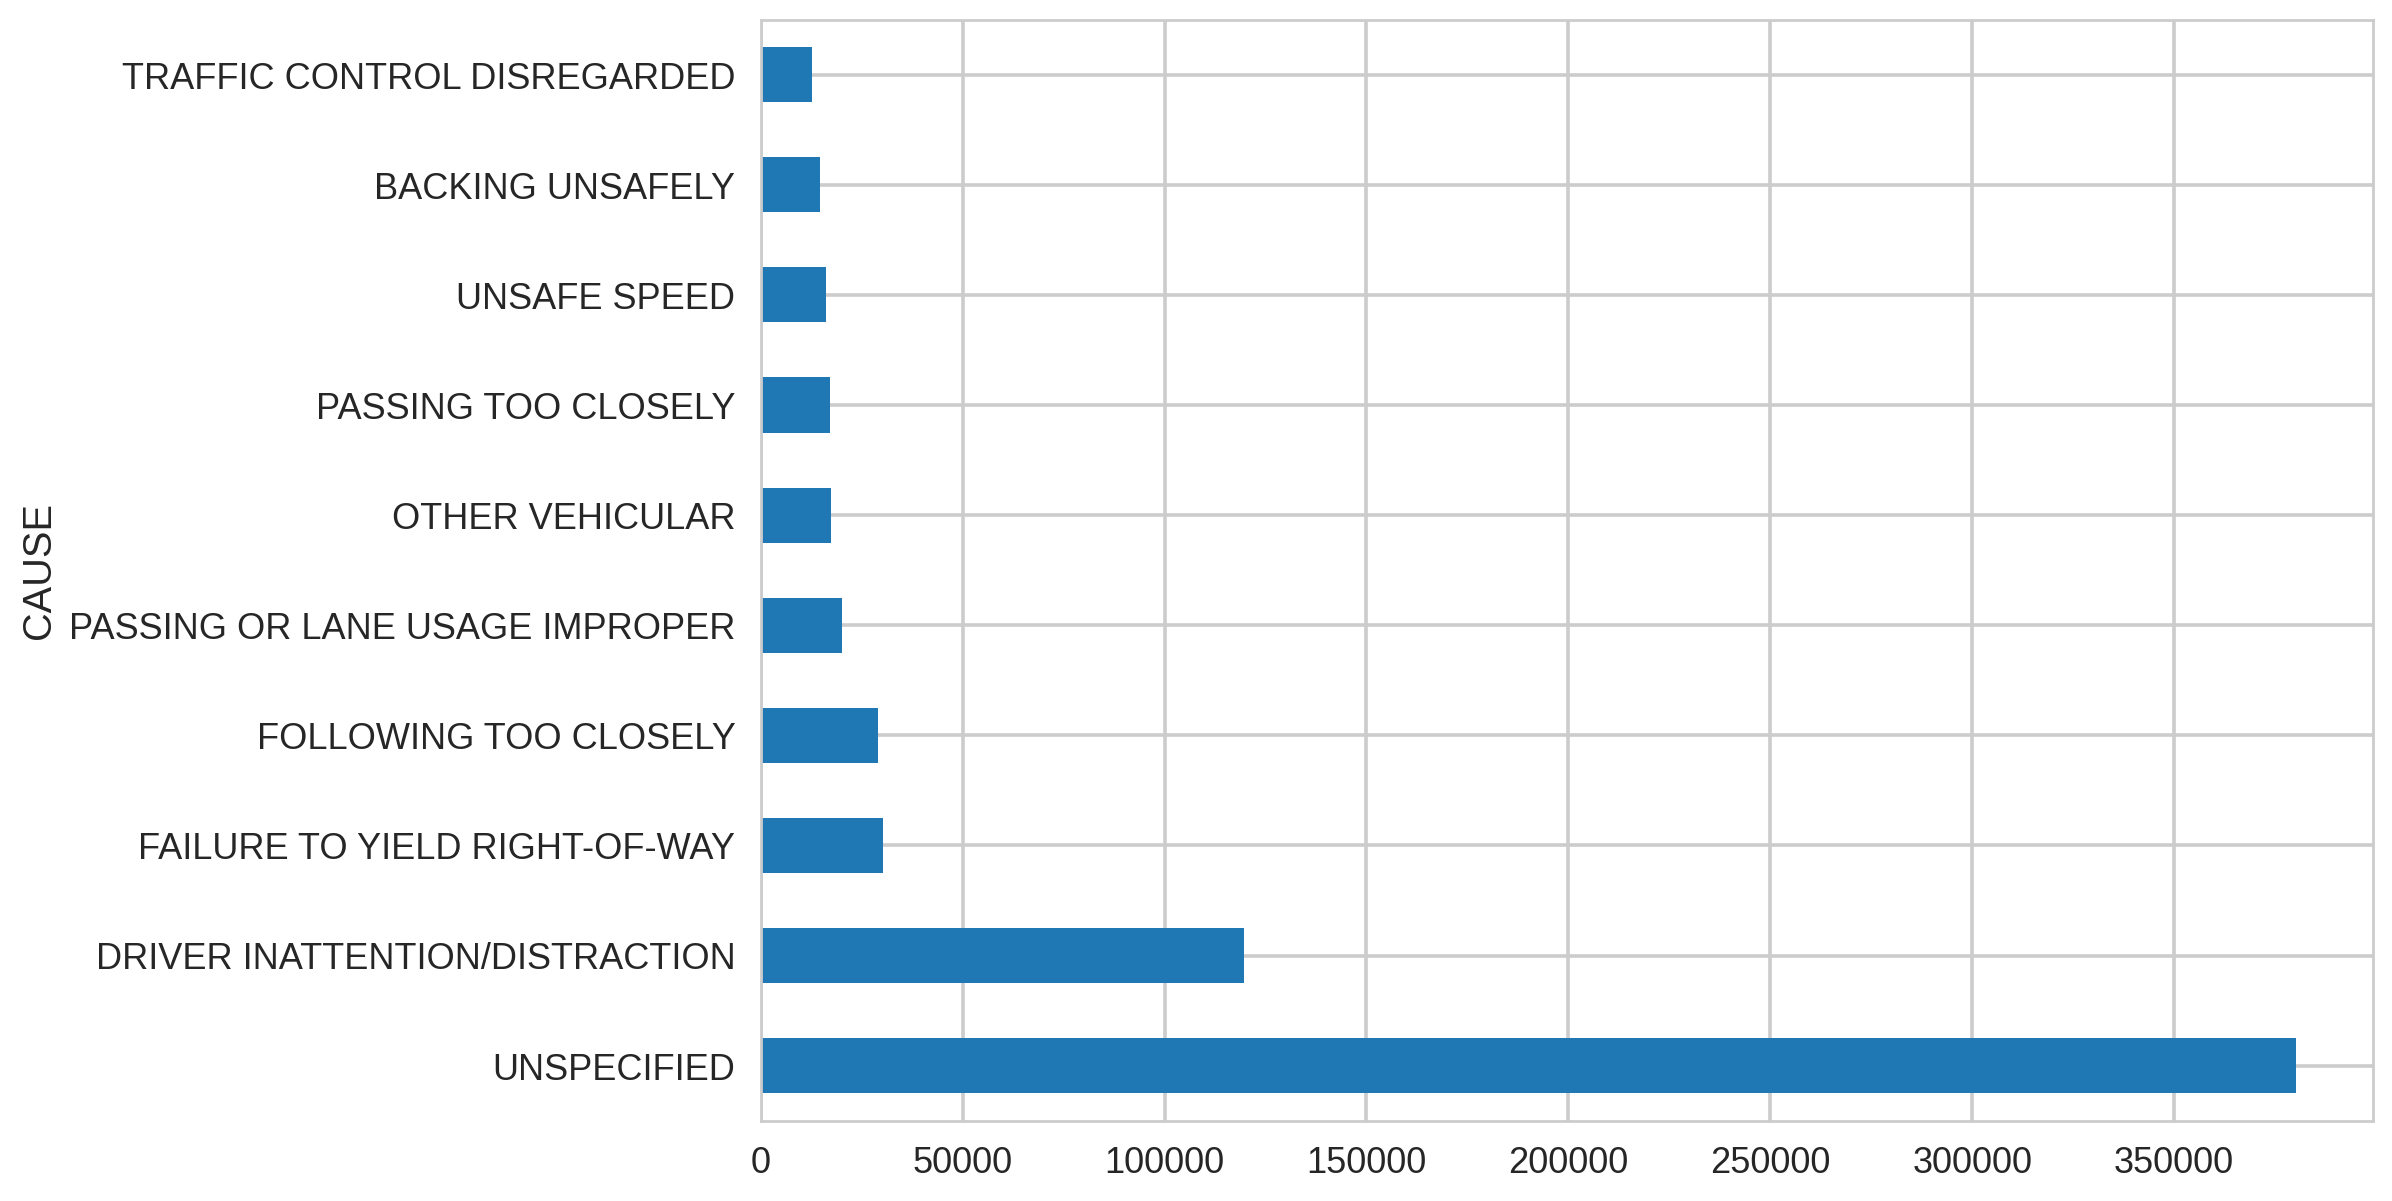

In [13]:
# plot the top ten reasons
v['CAUSE'].value_counts().head(10).plot(kind='barh')

In [14]:
# The difference between "COUNT(DISTINCT UNIQUE_KEY)"
# instead of COUNT(*). The former counts accidents, the later vehicles
factors_sql = '''
	SELECT CAUSE, COUNT(*) AS cnt
  FROM vehicles_involved
  WHERE UNIQUE_KEY IN (
  	SELECT UNIQUE_KEY
    FROM collisions
    WHERE DATE_TIME > '2020-01-01'
  )
  GROUP BY CAUSE
  ORDER BY cnt DESC
'''

with engine.connect() as connection:
	factors_df = pd.read_sql(text(factors_sql), con=connection)

factors_df.head(10)

,CAUSE,cnt
0,UNSPECIFIED,380188
1,DRIVER INATTENTION/DISTRACTION,119607
2,FAILURE TO YIELD RIGHT-OF-WAY,30149
3,FOLLOWING TOO CLOSELY,29145
4,PASSING OR LANE USAGE IMPROPER,19998
5,OTHER VEHICULAR,17356
6,PASSING TOO CLOSELY,17255
7,UNSAFE SPEED,16128
8,BACKING UNSAFELY,14614
9,TRAFFIC CONTROL DISREGARDED,12706


<Axes: ylabel='CAUSE'>

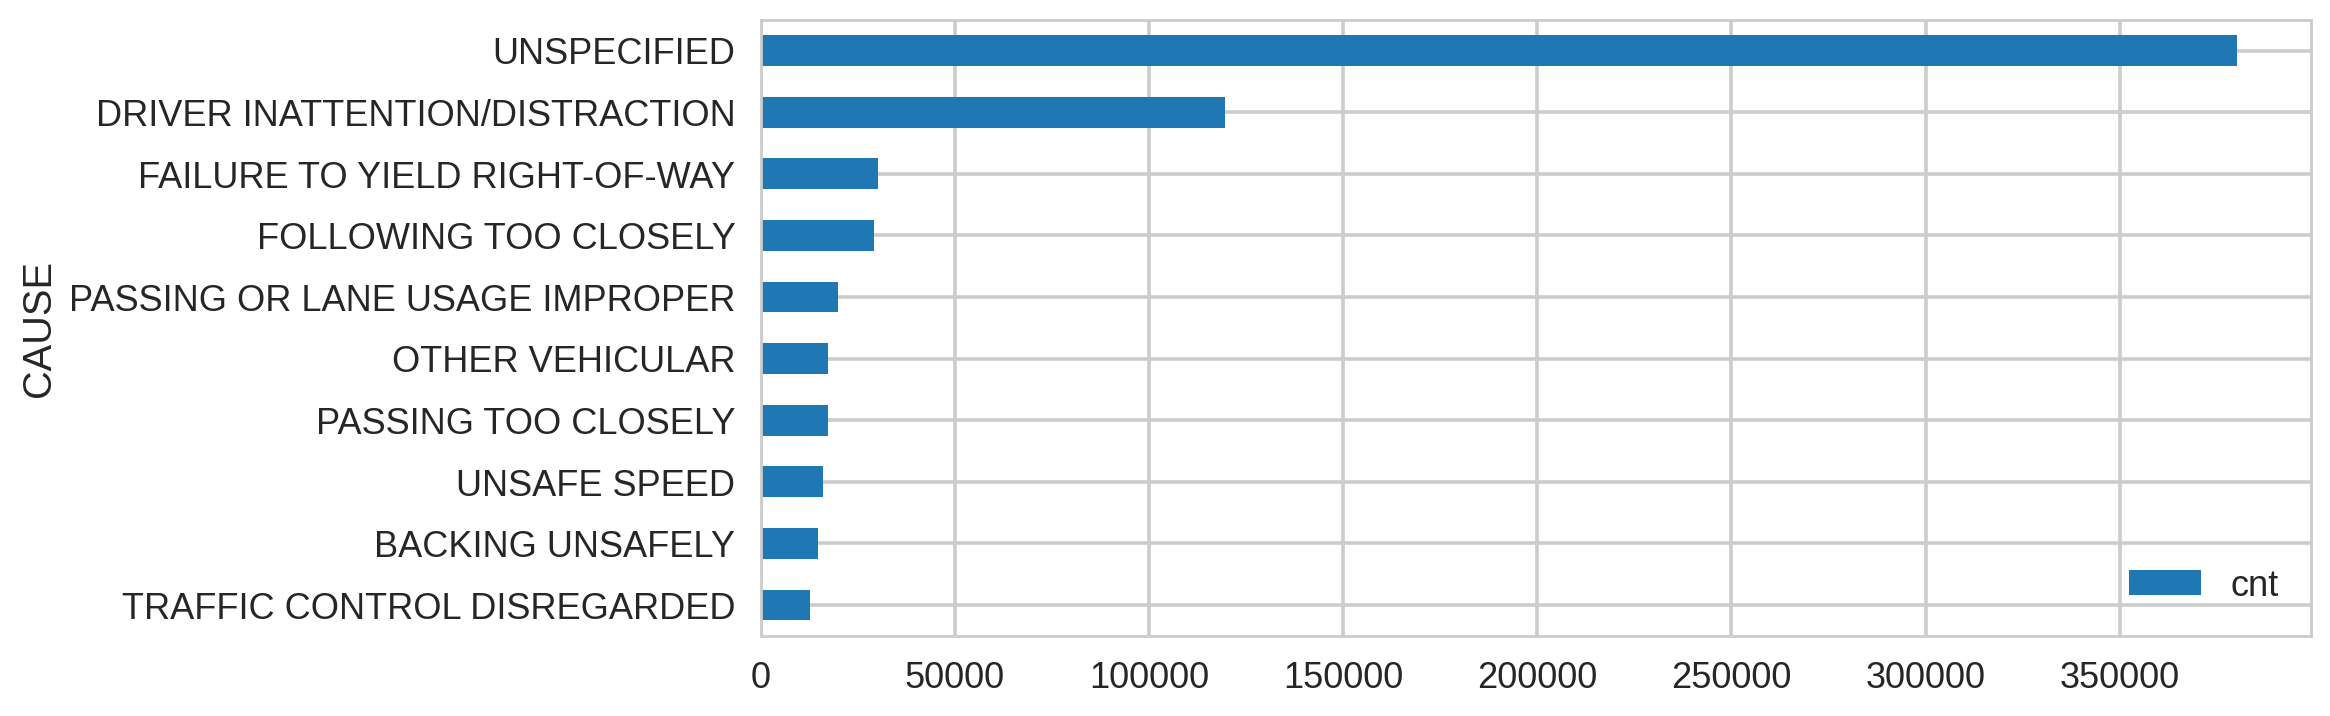

In [15]:
(
 factors_df
 .set_index('CAUSE') # Make "CAUSE" the x-axis for the plot
 #.drop("UNSPECIFIED") # uncomment if you want to eliminate "UNSPECIFIED" (the top-1)
 .head(10) # keep the top-10 factors
 .sort_values('cnt')
 .plot(
     kind='barh',
     figsize=(10,4)
  )
)

<Axes: ylabel='BOROUGH'>

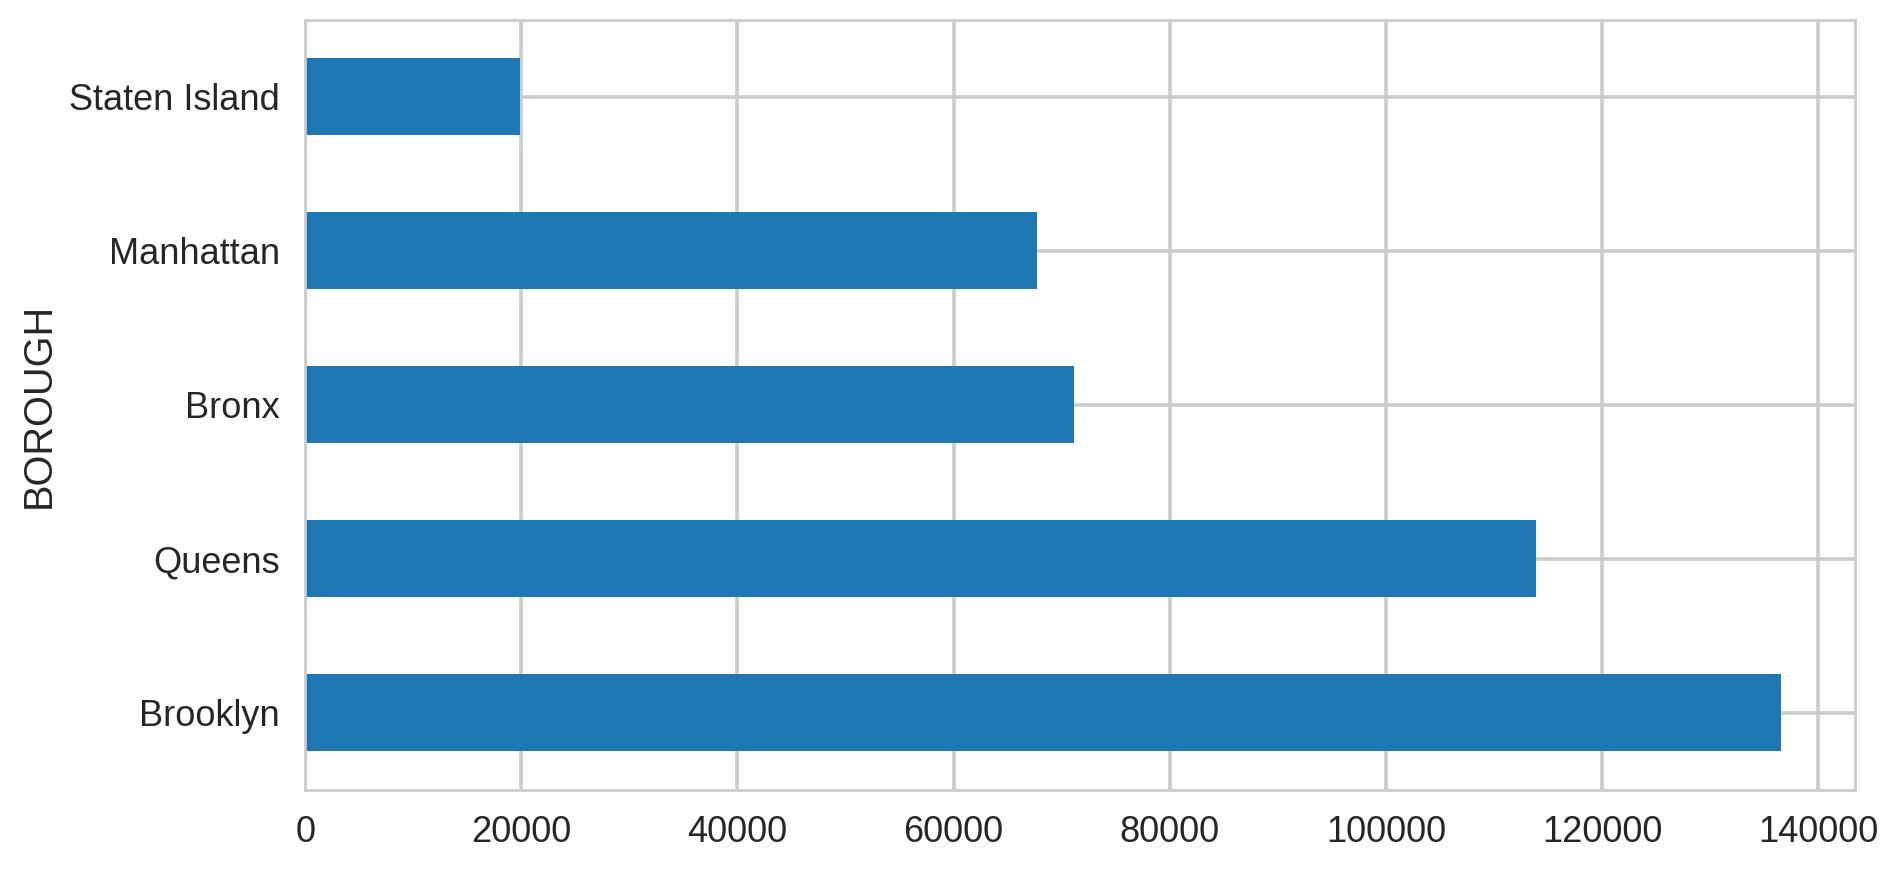

In [16]:
#Breakdown the num of collision by boro

c['BOROUGH'].value_counts().plot(kind='barh', figsize=(10,5))


<Axes: ylabel='BOROUGH'>

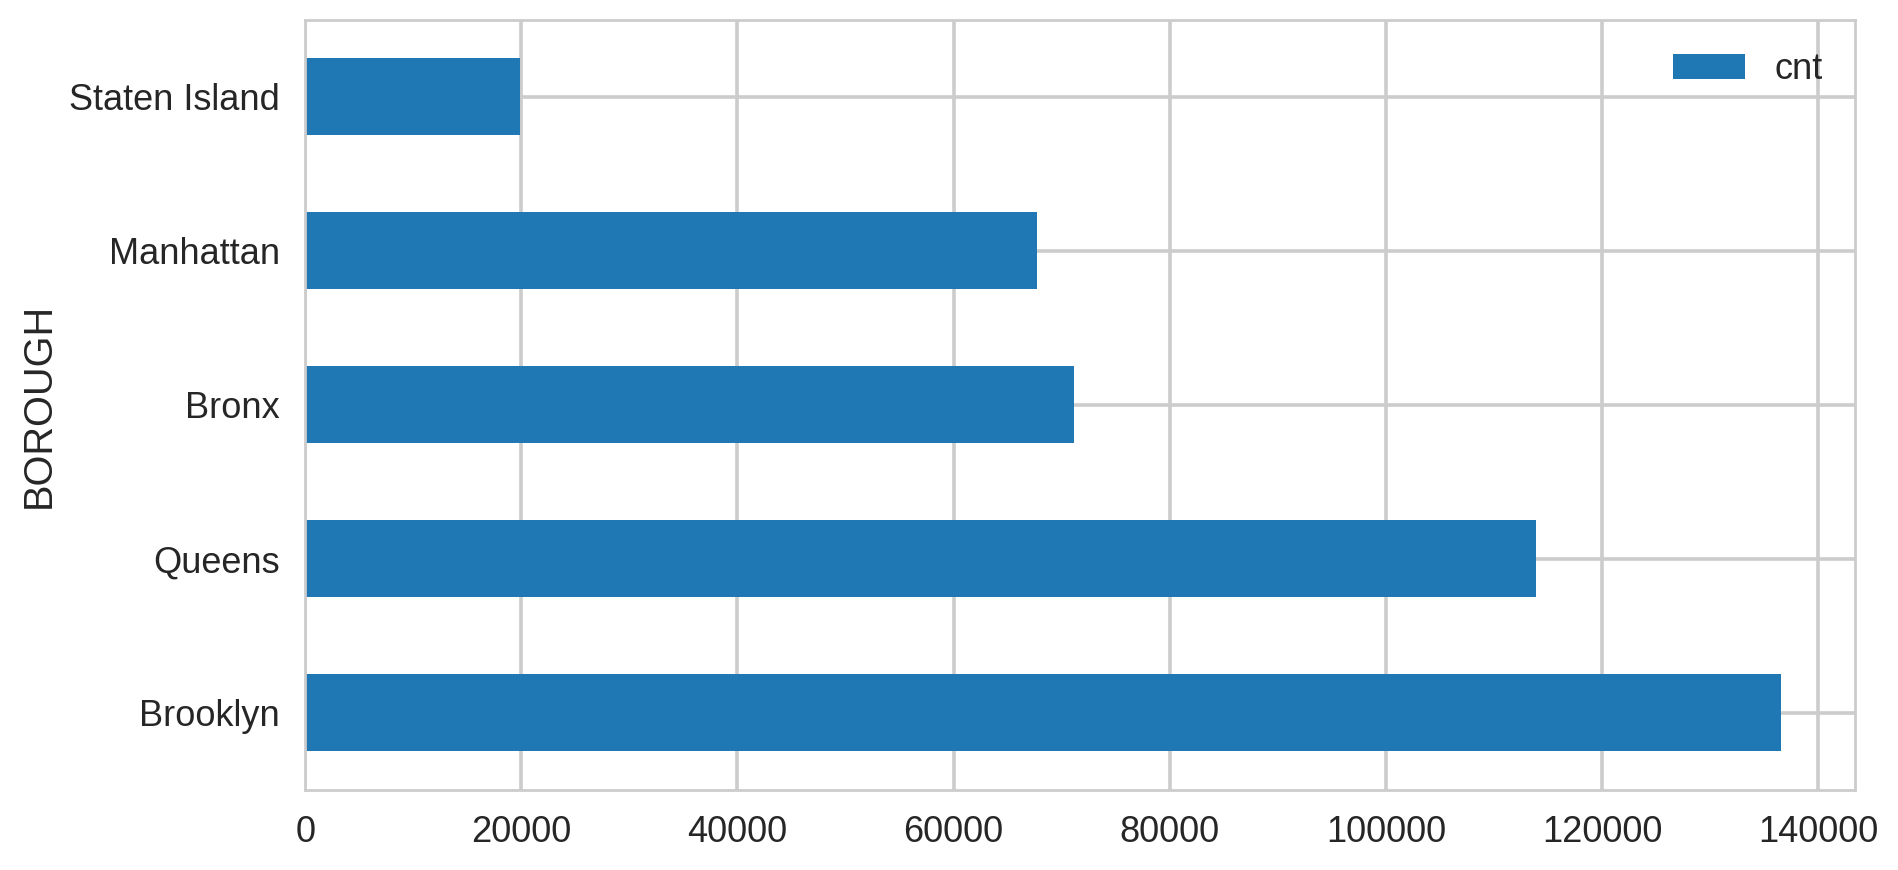

In [17]:
# Notice that you can remove the date time restriction and you
# will get the results back equally fast. If you try to load the
# whole collisions table in a dataframe, and then do the value_counts
# or a pivot table, it may take quite a while.

boro_sql = '''
	SELECT BOROUGH, COUNT(*) AS cnt
  FROM collisions
  WHERE DATE_TIME > '2020-01-01'
  GROUP BY BOROUGH
  ORDER BY cnt DESC
'''

with engine.connect() as connection:
	boro_df = pd.read_sql(text(boro_sql), con=connection)

(
    boro_df
    .plot(
        kind='barh',
        x='BOROUGH',
        y='cnt',
        figsize=(10,5)
    )
)

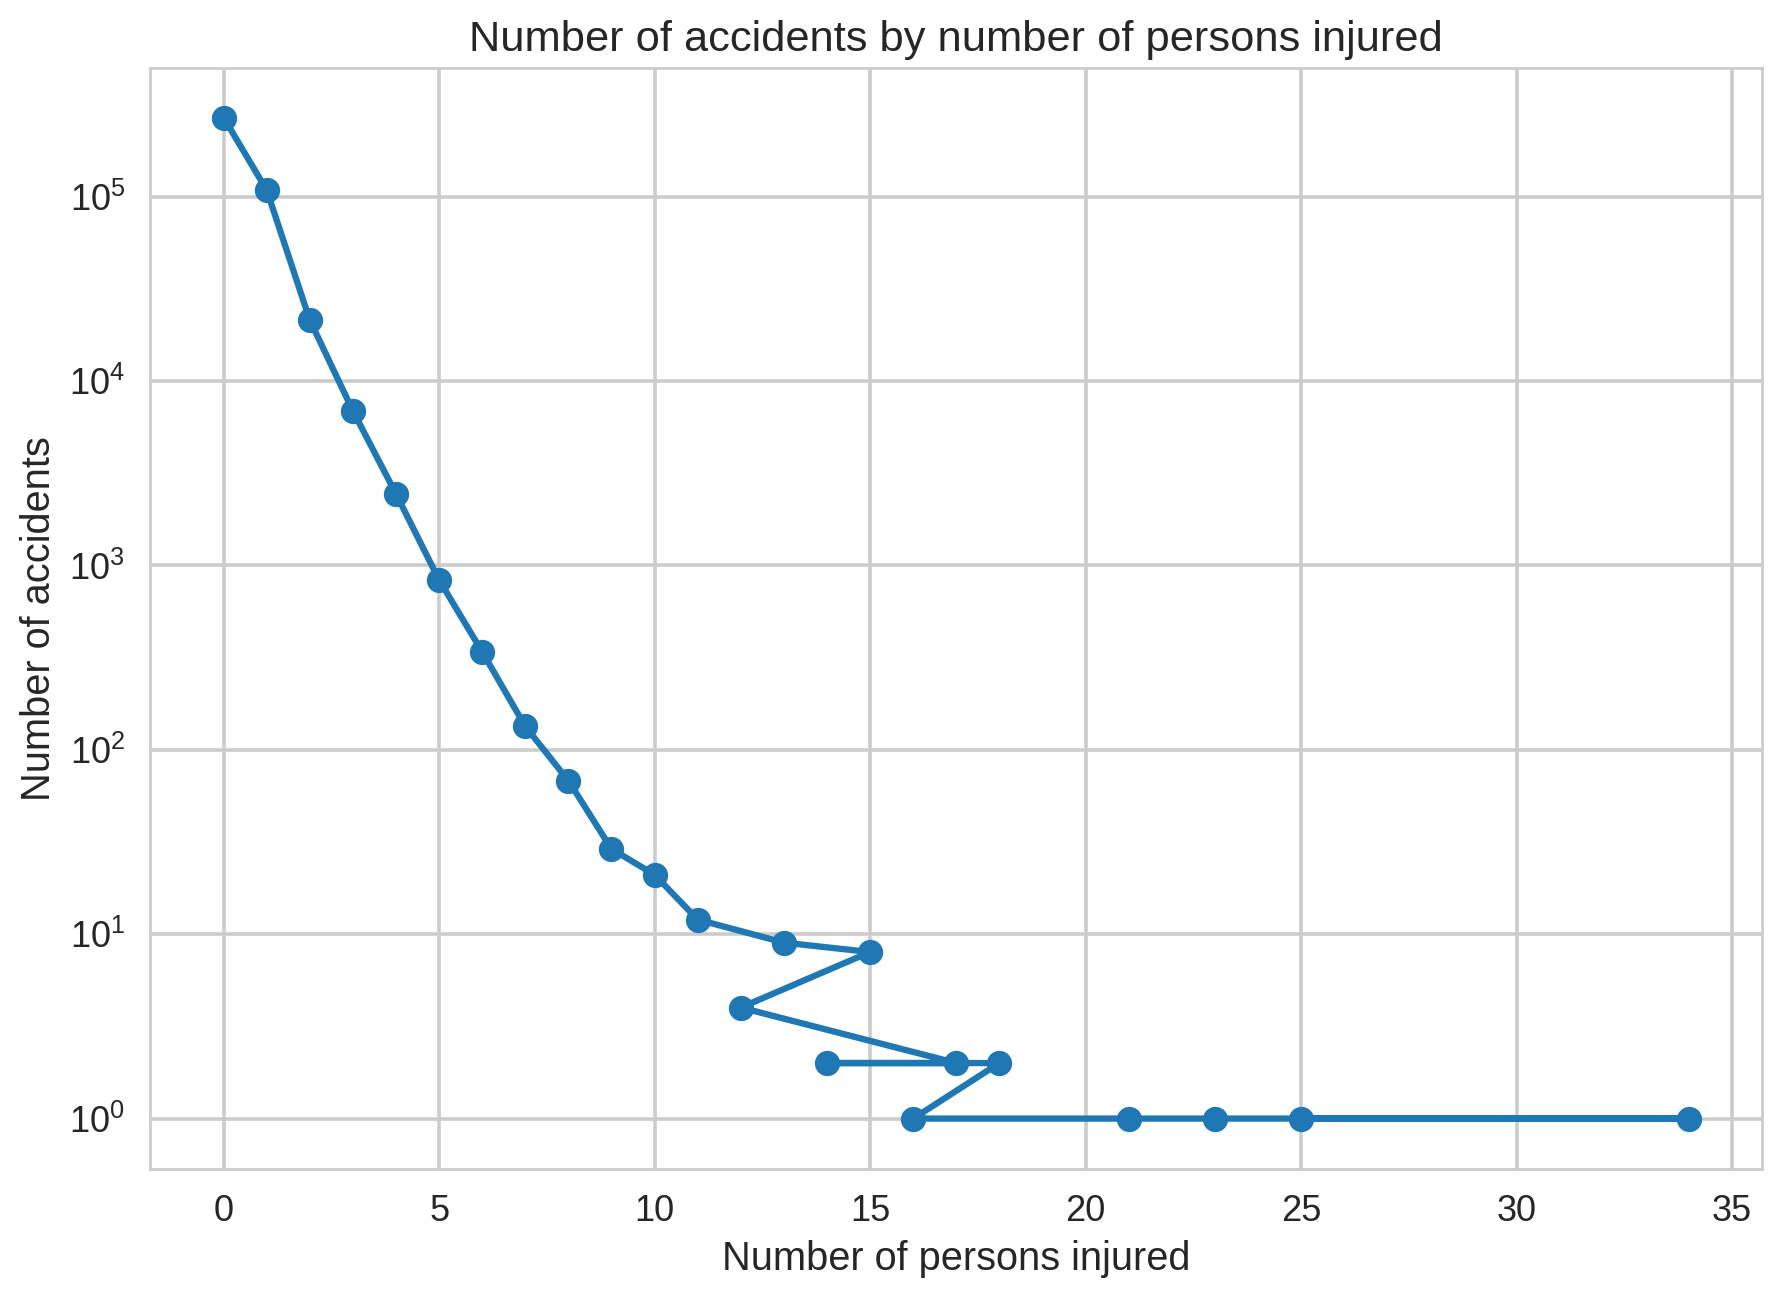

In [18]:
'''how many collisions had 0 persons injured, 1 persons injured, etc. persons
 injured in each accident. Use the value_counts() approach. You may also find
 the .plot(logy=True) option useful when you create the plot to make the y-axis
 logarigthmic '''

 # 'chain' stye of writing data manipulation operations
plot = (
    c['PERSONS_INJURED']      #takes the num of inj column
    .value_counts()           # compute the freq of each value, default for value cnt
    .plot(                    # plot results
        kind= 'line',          # use line plot because the z-axis is numeric/cont
        marker='o',            # use circles to mark the points
        logy=True,             #make y-axis logarithmic
        rot=0                 # rotate the x-axis labels
    )

)
plot.set_xlabel('Number of persons injured')
plot.set_ylabel('Number of accidents')
plot.set_title('Number of accidents by number of persons injured')
pass

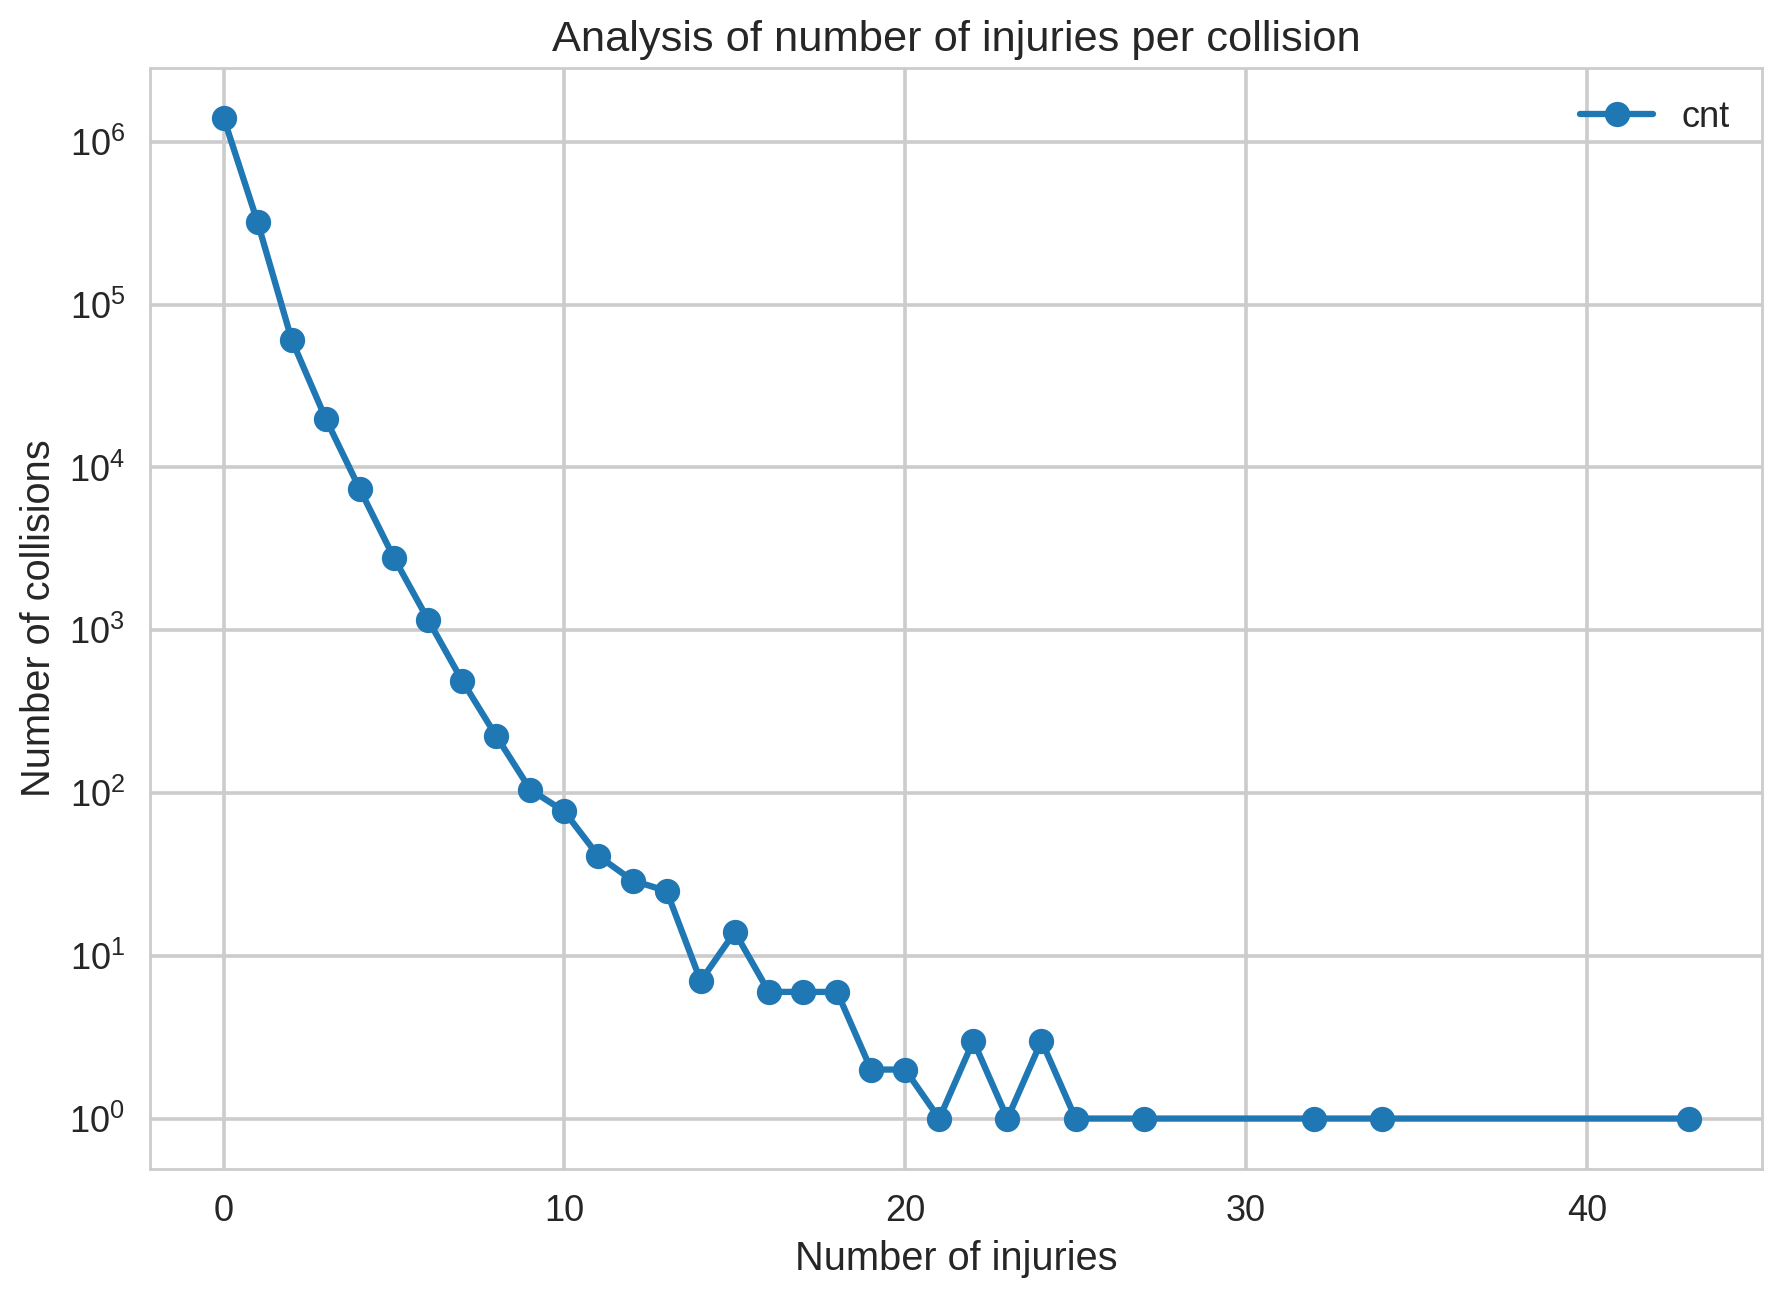

In [19]:
injuries_sql = '''
	SELECT PERSONS_INJURED, COUNT(*) AS cnt
  FROM collisions
  -- WHERE DATE_TIME > '2020-01-01'
  GROUP BY PERSONS_INJURED
  ORDER BY cnt DESC
'''

with engine.connect() as connection:
	injuries_df = pd.read_sql(text(injuries_sql), con=connection)

# "Chain" style of writing data maniputation operations
plot = (
    injuries_df # take the num of injuries column
    .sort_values('PERSONS_INJURED')
    .plot( # and plot the results
        x = 'PERSONS_INJURED',
        y = 'cnt',
        kind='line', # we use a line plot because the x-axis is numeric/continuous
        marker='o',  # we use a marker to mark where we have data points
        logy=True, # make the y-axis logarithmic
    )
)
plot.set_xlabel("Number of injuries")
plot.set_ylabel("Number of collisions")
plot.set_title("Analysis of number of injuries per collision")
pass

(a) Compute the average number of injuries and deaths per accident, broken down by borough. Use the pivot_table functionality, putting BOROUGH as the index. You can answer this query by generating two separate tables, or you can create a single table by using the fact that you can pass a list of attributes/columns to the values parameter of the pivot table.

(b) Repeat the exercise above, but break down the average number of deaths and injuries using the cause for the accident. (Do not worry that each accident may have multiple causes.) You will need to join the tables collisions and vehicles_involves; you can do the join either in SQL or in pandas, using the pd.merge command. Use the sort_values command to sort the results, putting on top the contributing factors that generate the highest number of deaths. Limit to the 10-deadliest causes.

In [20]:
# create pivot table
pd.pivot_table(
    data = c,
    index = 'BOROUGH',
    aggfunc = 'mean',
    values = ['PERSONS_INJURED', 'PERSONS_KILLED']
)

<ipython-input-20-dbc717b94c71>:2: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pd.pivot_table(


,PERSONS_INJURED,PERSONS_KILLED
BOROUGH,,
Bronx,0.478523,0.002824
Brooklyn,0.476760,0.002116
Manhattan,0.417380,0.002361
Queens,0.475895,0.002617
Staten Island,0.457490,0.003123


In [21]:
#pull in the min attributes, faster query and removes non needed data
sql = '''
        SELECT C.BOROUGH,
            AVG(C.PERSONS_INJURED) AS PERSONS_INJURED,
            AVG(C.PERSONS_KILLED) AS PERSONS_KILLED
        FROM collisions C
        WHERE DATE_TIME > '2020-01-01'
        GROUP BY C.BOROUGH
'''

with engine.connect() as conn:
    result = pd.read_sql(text(sql), con =conn)

result.set_index('BOROUGH')

,PERSONS_INJURED,PERSONS_KILLED
BOROUGH,,
Bronx,0.4785,0.0028
Brooklyn,0.4768,0.0021
Manhattan,0.4174,0.0024
Queens,0.4759,0.0026
Staten Island,0.4575,0.0031


In [22]:
# By keeping only the minimum attributes that we need, we speed up
# the execution, as we do not bring back data that we will discard anyway
sql = '''
  SELECT V.CAUSE
        , AVG(C.PERSONS_INJURED) AS PERSONS_INJURED
        , AVG(C.PERSONS_KILLED) AS PERSONS_KILLED
  FROM collisions C JOIN vehicles_involved V ON C.UNIQUE_KEY = V.UNIQUE_KEY
  WHERE DATE_TIME > '2020-01-01'
  GROUP BY V.CAUSE
'''
with engine.connect() as connection:
	result = pd.read_sql(text(sql), con=connection)

In [23]:
(
  result
 .set_index('CAUSE')
 .sort_values('PERSONS_KILLED',ascending=False)
 .head(20)

)


,PERSONS_INJURED,PERSONS_KILLED
CAUSE,,
LOST CONSCIOUSNESS,1.0288,0.0288
TINTED WINDOWS,0.8113,0.0283
ILLNESS,0.9469,0.0210
UNSAFE SPEED,0.7631,0.0135
PHYSICAL DISABILITY,0.8882,0.0118
PEDESTRIAN/BICYCLIST/OTHER PEDESTRIAN ERROR/CONFUSION,0.8405,0.0083
TRAFFIC CONTROL DISREGARDED,0.8712,0.0077
PAVEMENT DEFECTIVE,0.5683,0.0066
OBSTRUCTION/DEBRIS,0.4464,0.0050


##Break down the number of accidents by borough and cause.

In [24]:
# By keeping only the minimum attributes that we need, we speed up
# the execution, as we do not bring back data that we will discard anyway
sql = '''
  SELECT C.BOROUGH,  V.CAUSE, COUNT(DISTINCT C.UNIQUE_KEY) AS cnt
  FROM collisions C JOIN vehicles_involved V ON C.UNIQUE_KEY = V.UNIQUE_KEY
  WHERE DATE_TIME > '2020-01-01'
  GROUP BY C.BOROUGH,  V.CAUSE
'''
with engine.connect() as connection:
	result = pd.read_sql(text(sql), con=connection)

In [25]:
# create pivot
pivot = pd.pivot_table(
    data = result,          # we analyze the df (accidents)
    index='CAUSE',
    columns='BOROUGH',
    aggfunc='sum',
    values='cnt'
)

#create an extra column showing the total deaths across boroughs (columns)
pivot['Total'] = pivot.sum(axis='columns')

# sort the df by desc order of the values in the "total" column
pivot = pivot.sort_values('Total', ascending=False)

pivot.head(10)








BOROUGH,Bronx,Brooklyn,Manhattan,Queens,Staten Island,Total
CAUSE,,,,,,
UNSPECIFIED,51080.0,100054.0,44907.0,81576.0,13908.0,291525.0
DRIVER INATTENTION/DISTRACTION,15345.0,36129.0,19904.0,29572.0,6484.0,107434.0
FAILURE TO YIELD RIGHT-OF-WAY,3971.0,9321.0,3955.0,10530.0,1457.0,29234.0
FOLLOWING TOO CLOSELY,3971.0,7931.0,4402.0,9897.0,1107.0,27308.0
PASSING OR LANE USAGE IMPROPER,2811.0,5912.0,3629.0,6151.0,633.0,19136.0
PASSING TOO CLOSELY,3105.0,5773.0,3277.0,4253.0,326.0,16734.0
UNSAFE SPEED,3802.0,4387.0,1942.0,4966.0,706.0,15803.0
BACKING UNSAFELY,2458.0,4615.0,2527.0,4225.0,718.0,14543.0
OTHER VEHICULAR,3515.0,4494.0,3101.0,2526.0,362.0,13998.0


##find dates wth the most accidents

In [28]:
sql = '''
  SELECT DATE(DATE_TIME) AS accident_date, COUNT(*) AS cnt
  FROM collisions
  GROUP BY DATE(DATE_TIME)
  ORDER BY cnt DESC
'''

with engine.connect() as connection:
	date_df = pd.read_sql(text(sql), con=connection)


date_df

,accident_date,cnt
0,2018-11-15,987
1,2014-01-21,958
2,2017-12-15,929
3,2017-05-19,901
4,2017-05-18,837
...,...,...
4355,2020-04-23,96
4356,2020-04-09,95
4357,2020-04-19,91
4358,2020-03-29,89


In [29]:
(
  pd.pivot_table(
      data = date_df,
      index = 'accident_date',
      values = 'cnt',
  )
  # .resample('1D').sum()
  .sort_values('cnt', ascending=False)
)

,cnt
accident_date,
2018-11-15,987.0
2014-01-21,958.0
2017-12-15,929.0
2017-05-19,901.0
2017-05-18,837.0
...,...
2020-04-12,96.0
2020-04-09,95.0
2020-04-19,91.0


##Plot the number of accidents per day. Try to eliminate the effects of seasonality by resampling and calculating values on a weekly or monthly basis (Hint: Ensure that your date column is in the right datatype and that it is properly sorted, before attempting a resample)

<Axes: xlabel='accident_date'>

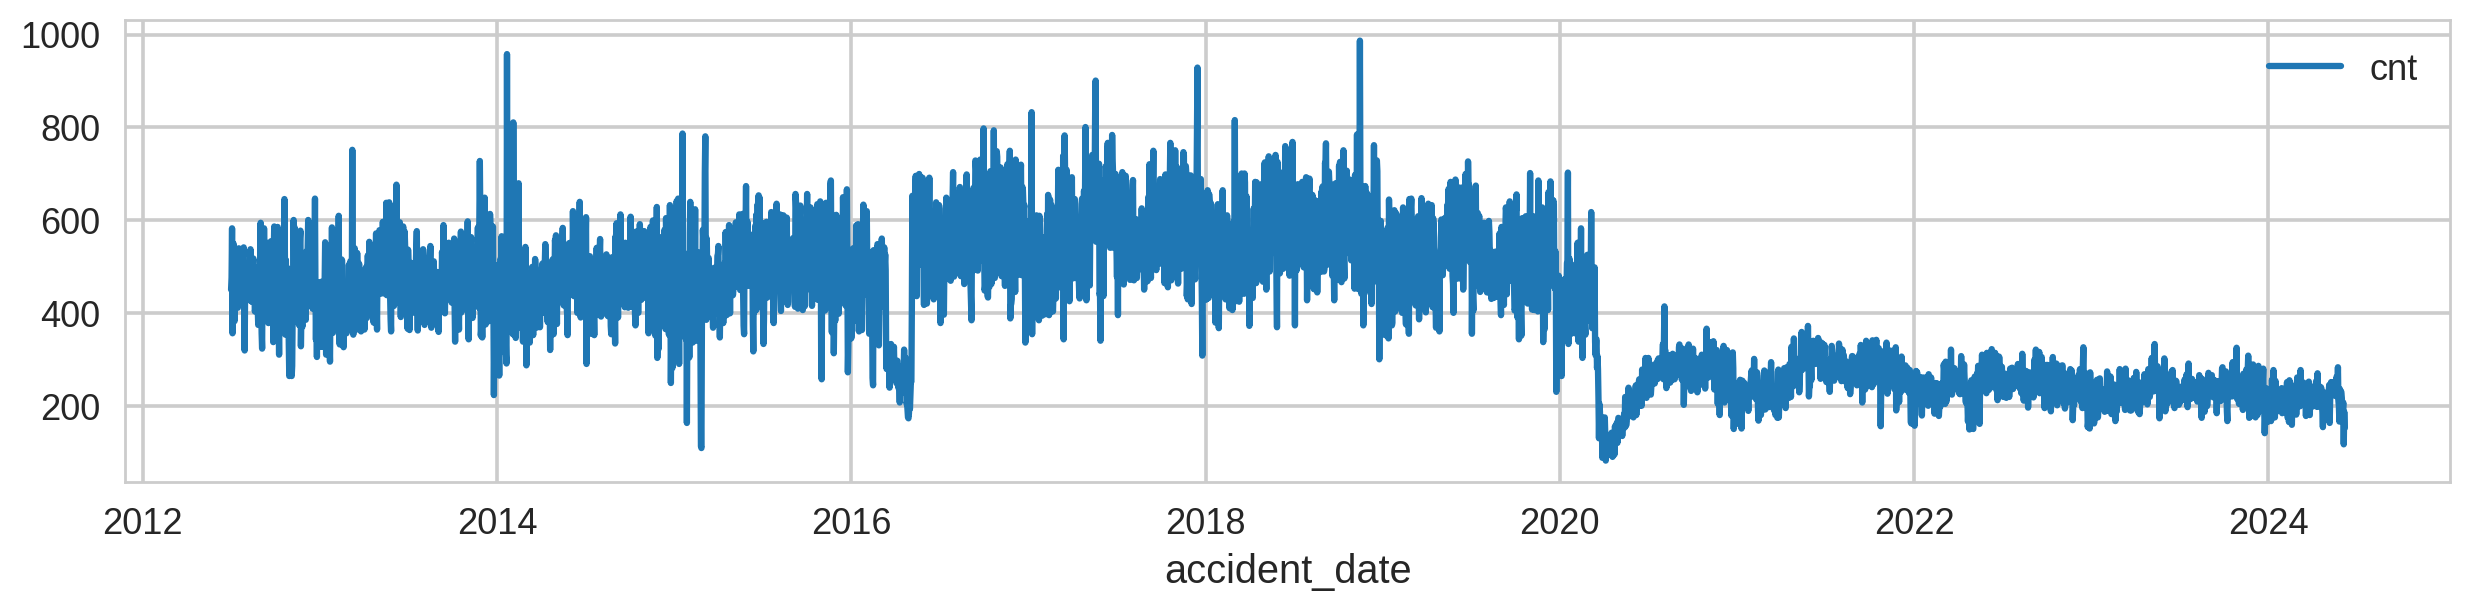

In [31]:
(
  pd.pivot_table(
      data = date_df,
      index = 'accident_date',
      values = 'cnt',
  )
  # .resample('1W') # take periods of 1 week
  # .sum() # sum the number of accidents per period
  .plot(figsize=(15,3)) # plot the result
)

<Axes: xlabel='date'>

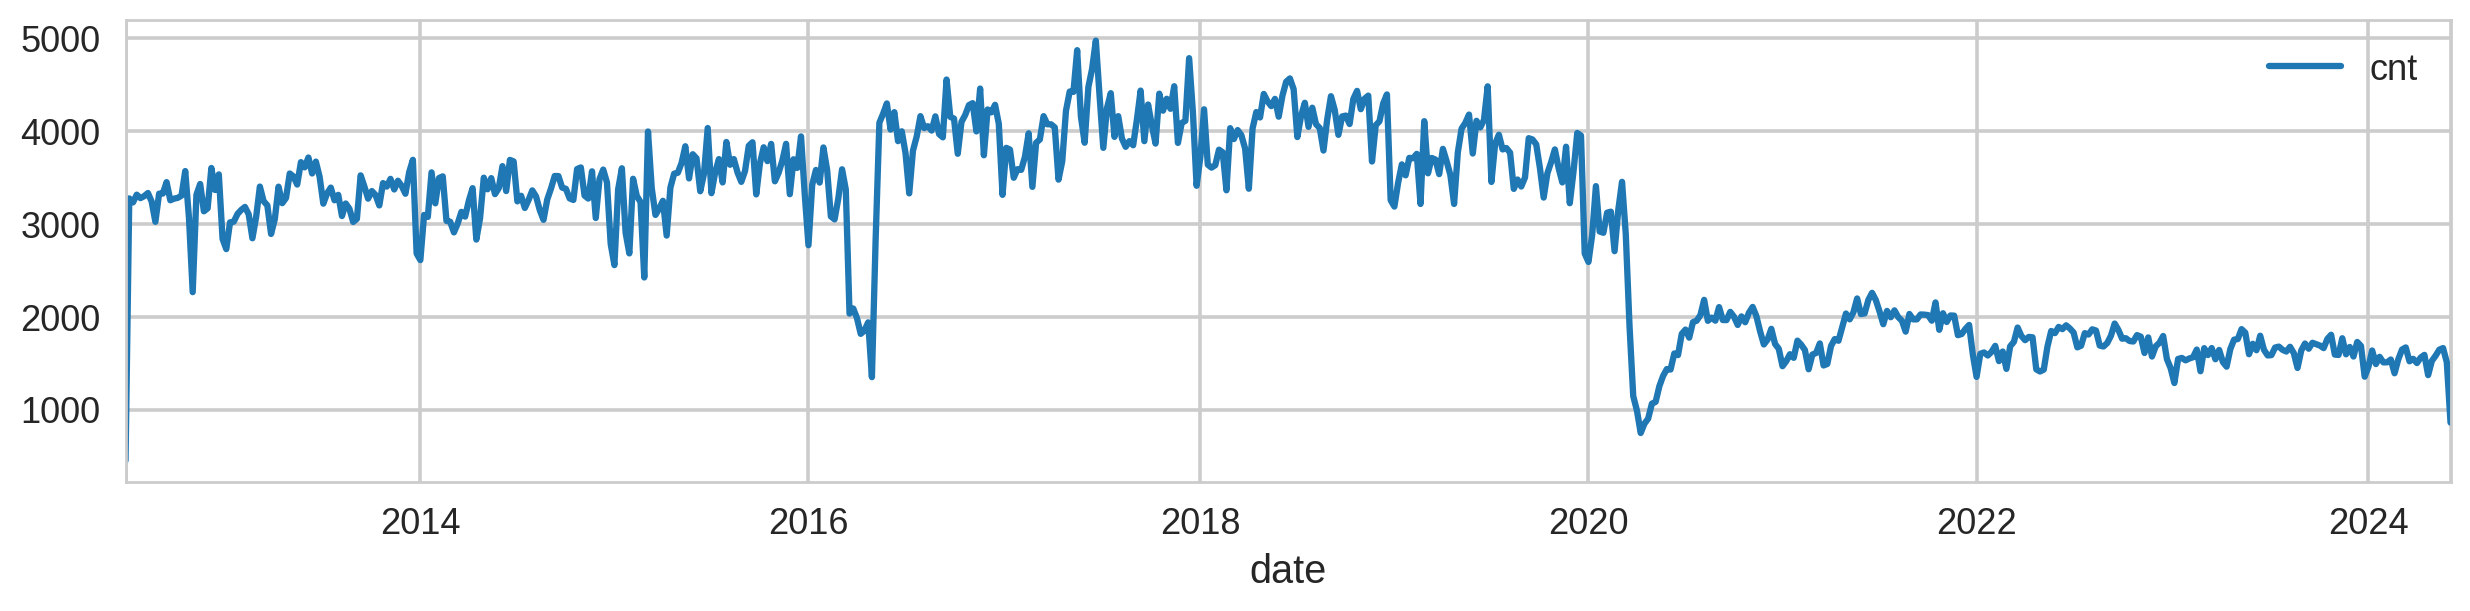

In [34]:
# Convert the 'accident_date' from 'object' to datetime
date_df['date'] = pd.to_datetime(date_df['accident_date'])

(
  pd.pivot_table(
      data = date_df,
      index = 'date',
      values = 'cnt',
  )
  .resample('1W') # take periods of 1 week
  .sum() # sum the number of accidents per period
  .plot(figsize=(15,3)) # plot the result
)

analyze the timing patterns of accidents that lead to death or injury.

We will do the analysis by creating histograms showing the frequency of deadly vs non-deadly accidents throughout the day. By comparing the two histograms we will be able to understand if time of day is correlated with deadly accidents or not.

Steps to follow:

Create an HOUR column that captures the hour of the day that the accident happened.
Create a boolean column DEATH that is true when someone was killed in the accident (i.e., NUMBER OF PERSONS KILLED > 0).
Create a boolean column INJURY that is true when someone was injured in the accident (i.e., NUMBER OF PERSONS INJURED > 0).
Query the dataframe to get back the deadly accidents and create a histogram of deadly accidents over time. Do the same for non-deadly accidents.
To allow a more direct visual comparison of the two histograms, we want to merge them in one plot. Since the number of accidents without deaths is much higher, we want the histograms to be normalized (i.e., density=True).
It is also a good idea to make the histographs partially transparent, to allow for easier comparison of the two histograms.

In [36]:
# create query
sql = '''
    SELECT UNIQUE_KEY,
        DATE_TIME,
        HOUR(DATE_TIME) AS HOUR,
        PERSONS_KILLED > 0 AS DEATH,
        PERSONS_INJURED > 0 AS INJURY
    FROM collisions
'''

with engine.connect() as connection:
	df = pd.read_sql(text(sql), con=connection)


In [37]:
# Define the two subsets
deadly = df.query(" DEATH == True ")
noharm = df.query(" DEATH == False ")

<Axes: >

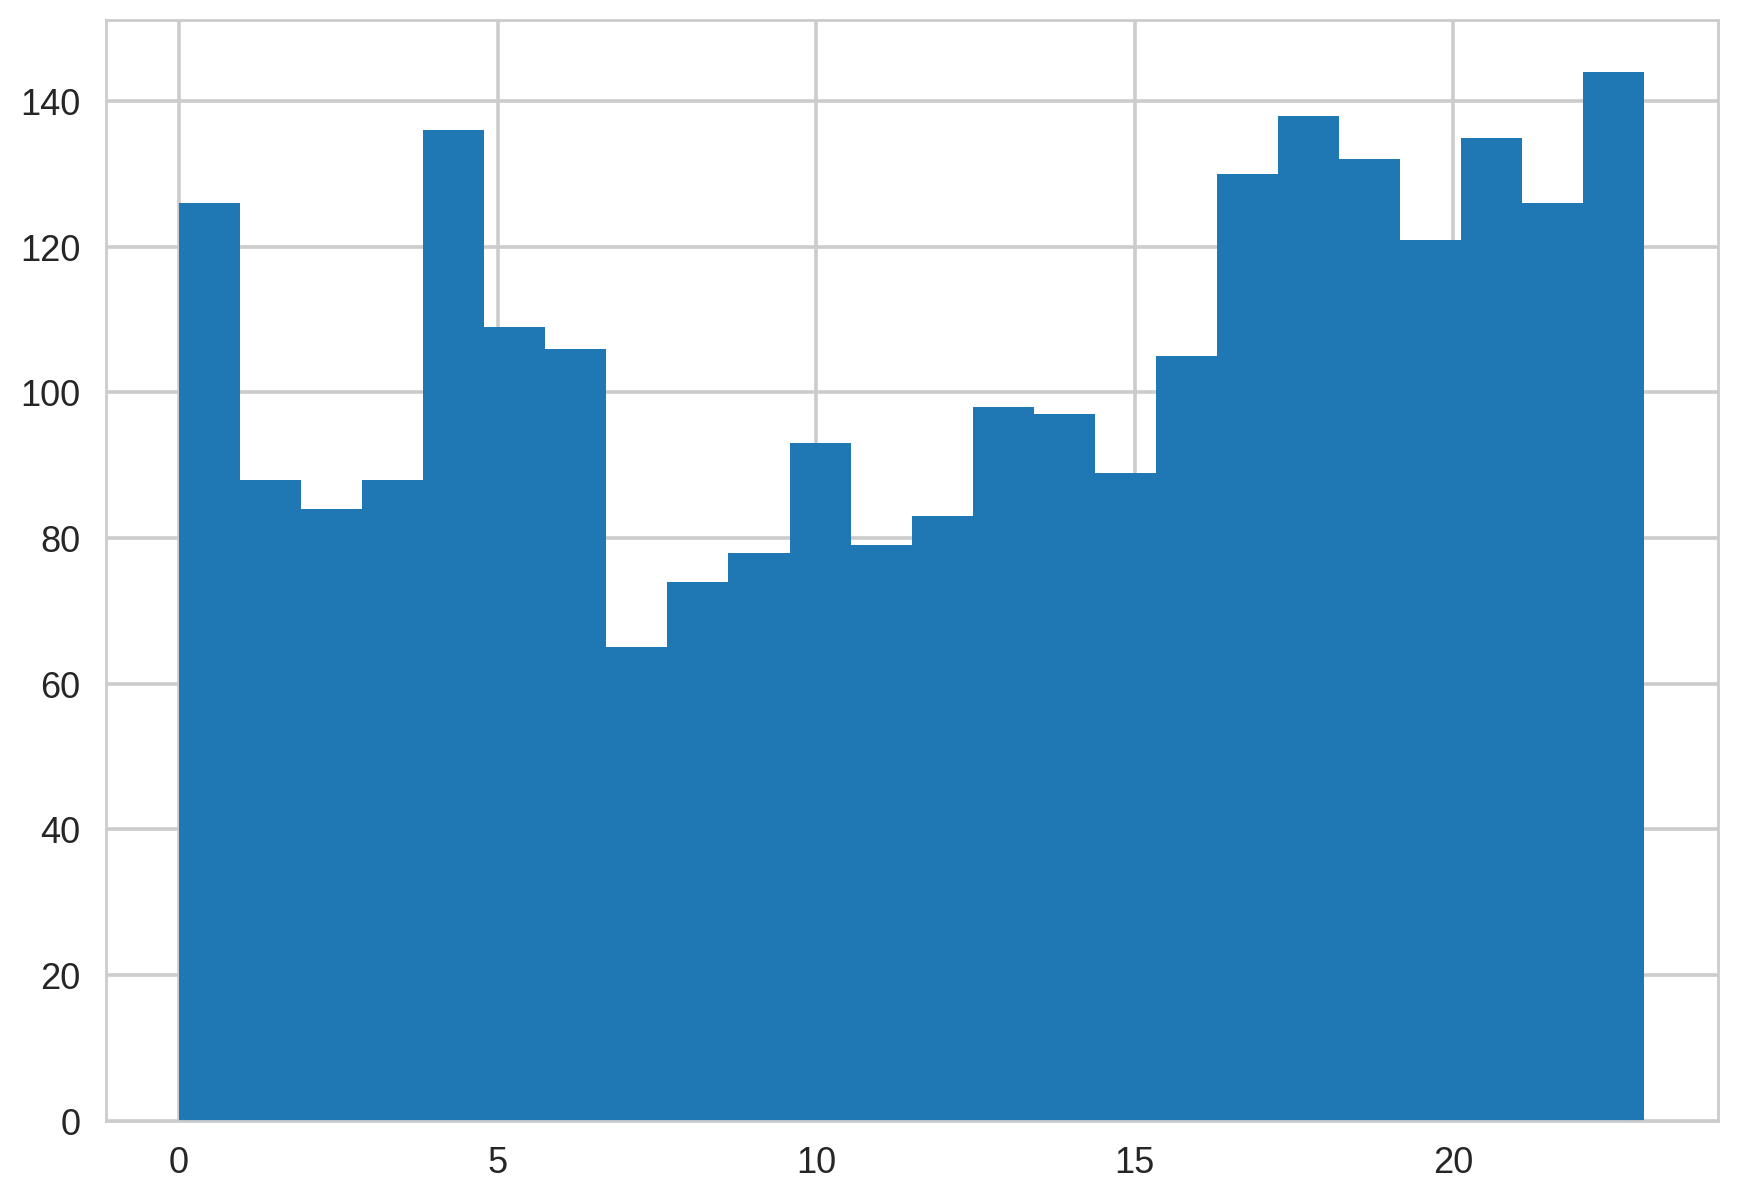

In [41]:
# create hist for both subsets

deadly['HOUR'].hist(bins=24)


<Axes: >

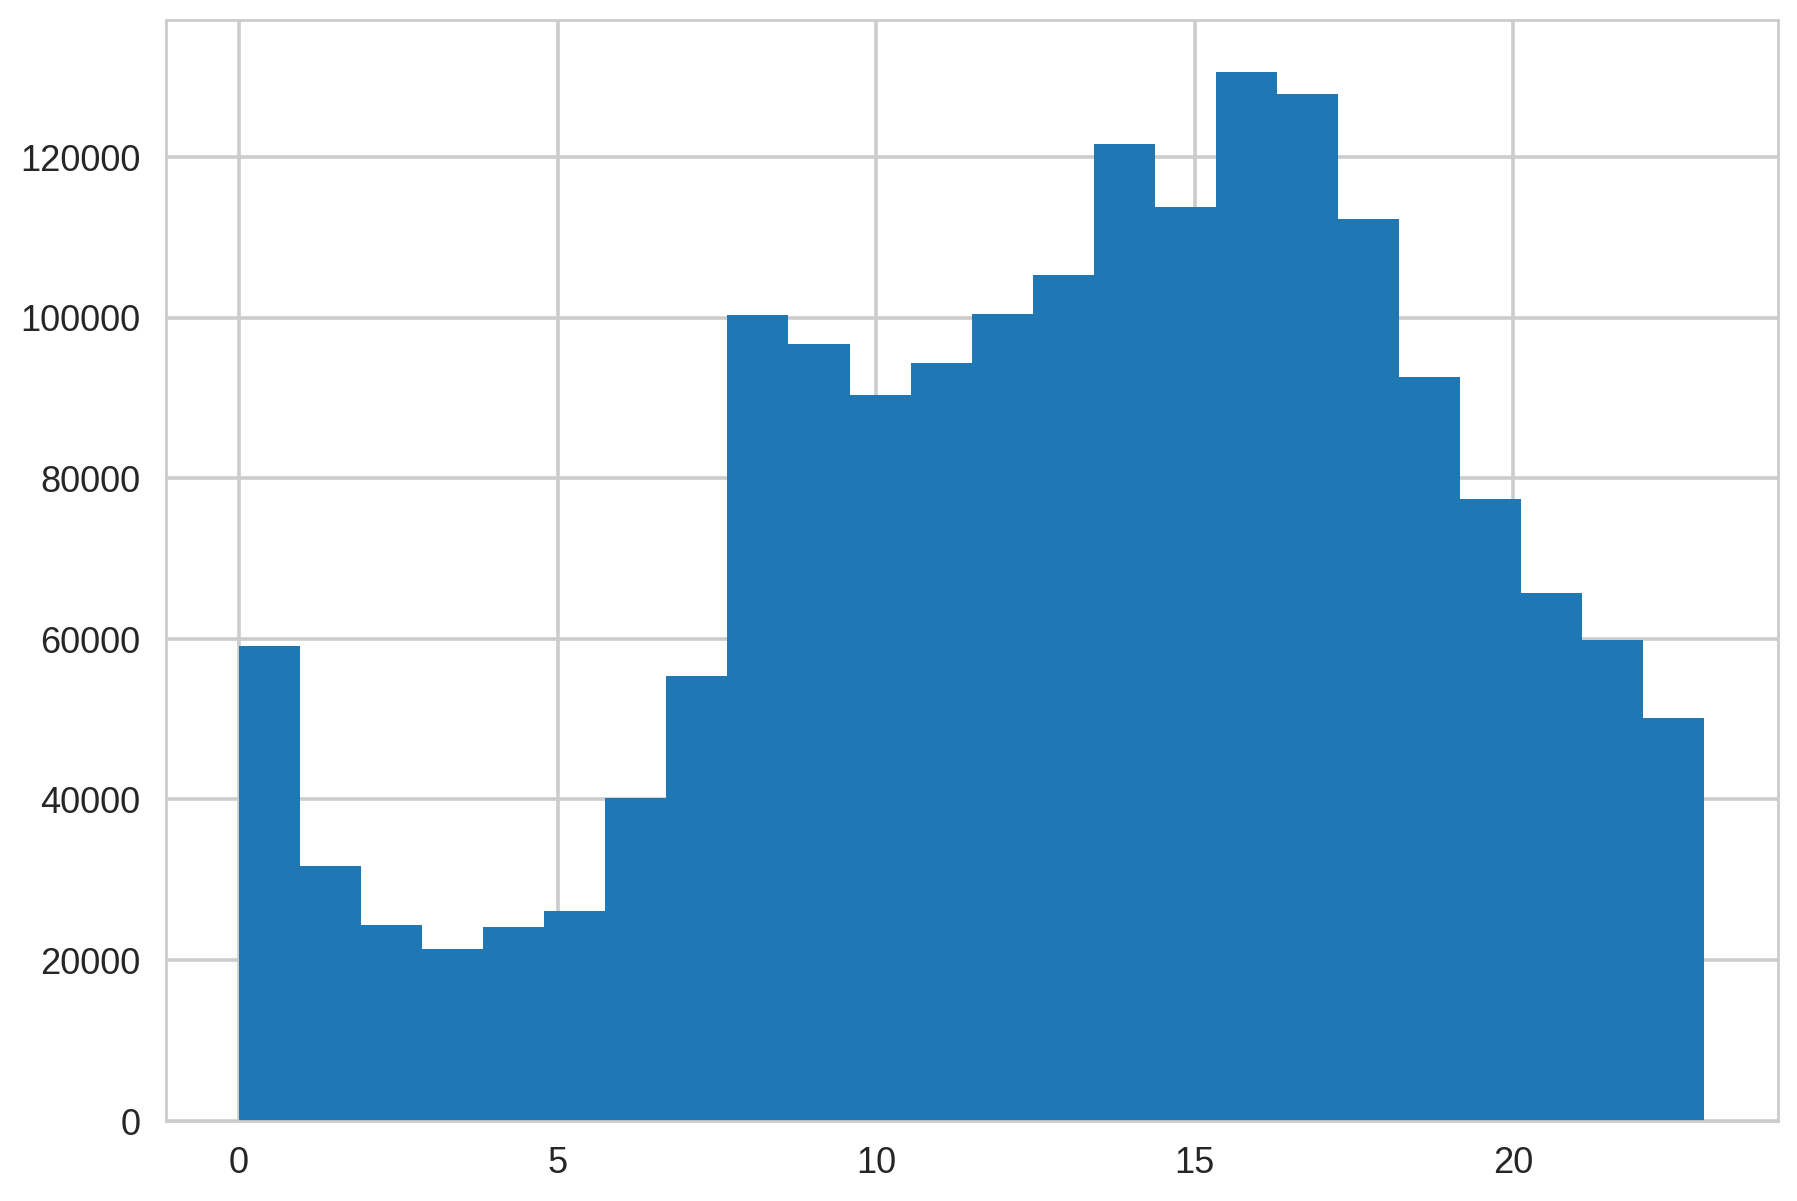

In [40]:
noharm['HOUR'].hist(bins=24)


<Axes: >

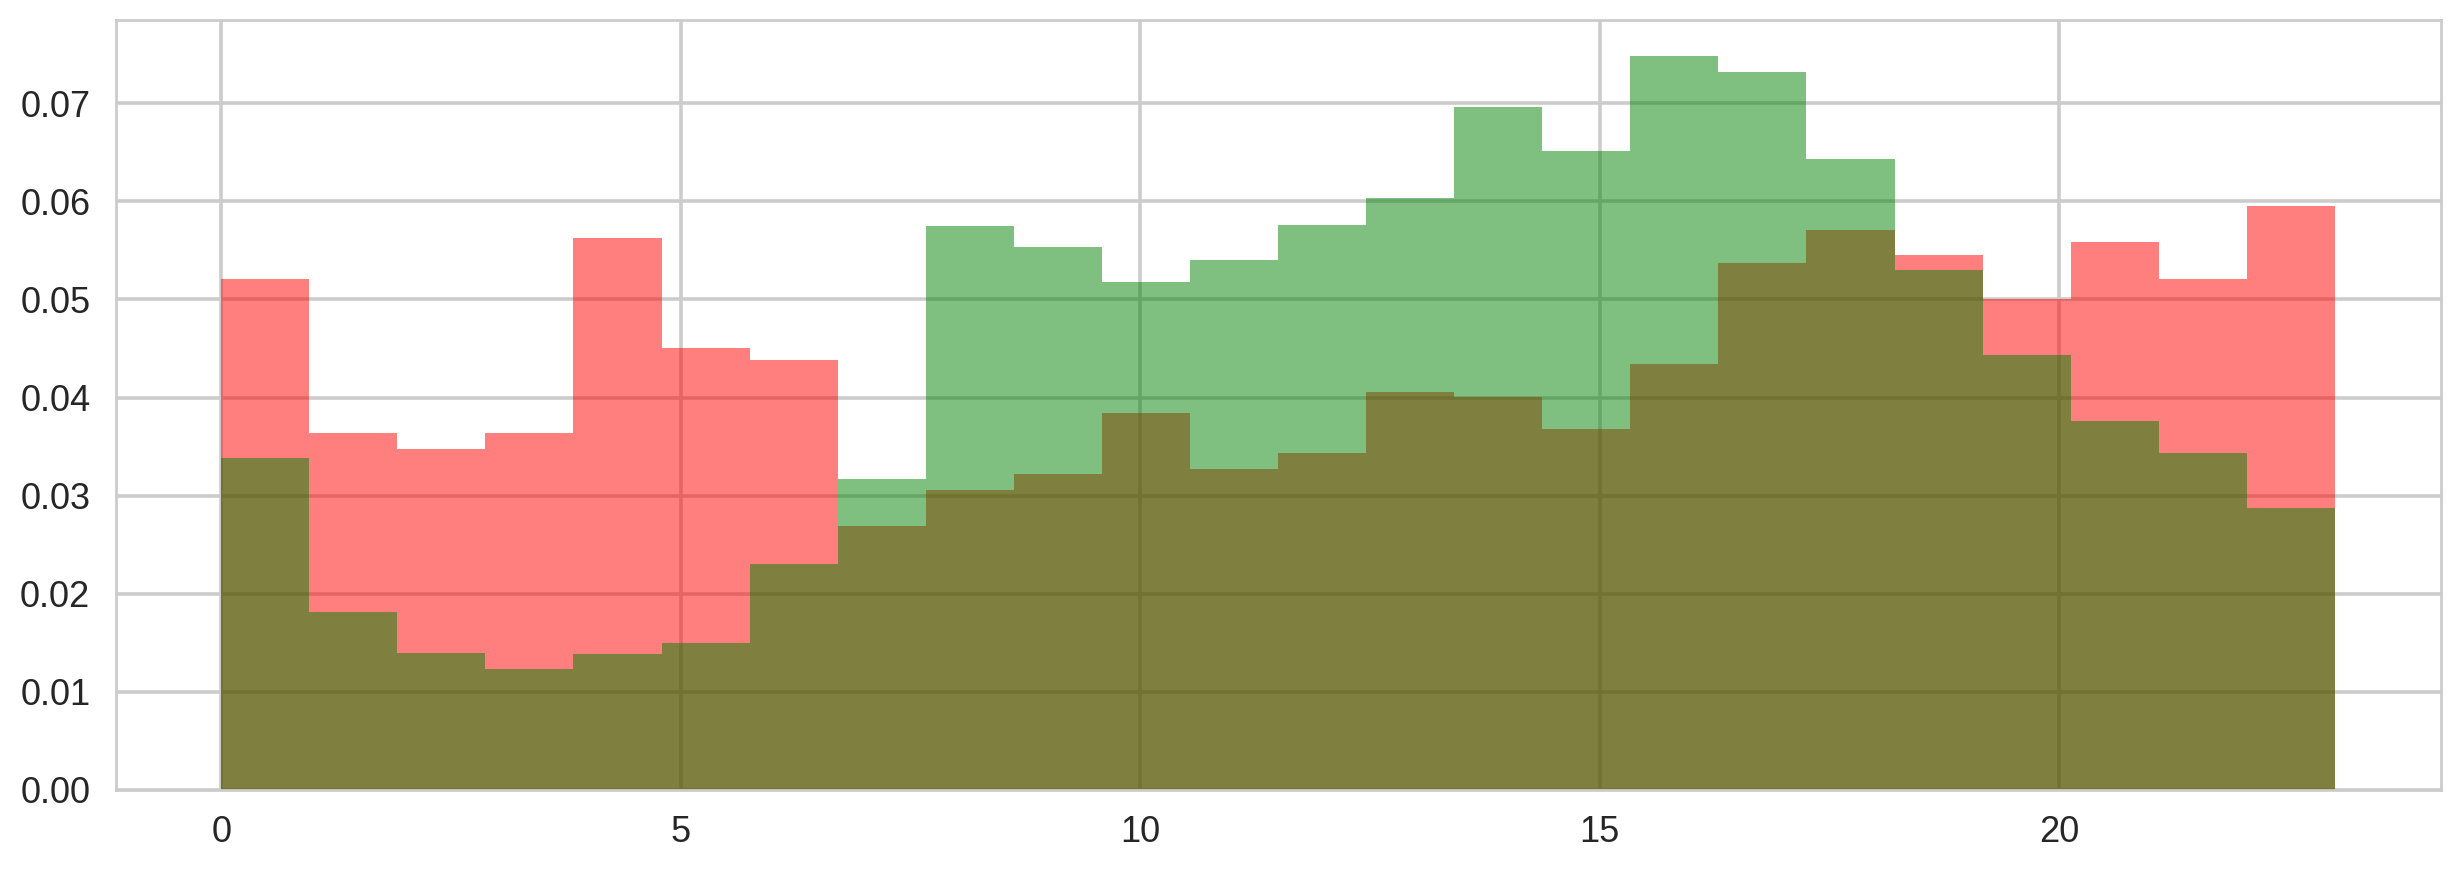

In [42]:
#overlay the two graphs

deadly['HOUR'].hist(
    bins=24, # one bar per hour
    figsize=(15,5),  # make the figure bigger
    density=True, # normalize the counts
    alpha=0.5,  # make the histogram semi-transparent
    color='red' # color red the deadly accidents
)

noharm['HOUR'].hist(
    bins=24,
    figsize=(15,5),
    density=True,
    alpha=0.5,
    color='green'
)

<Axes: xlabel='HOUR'>

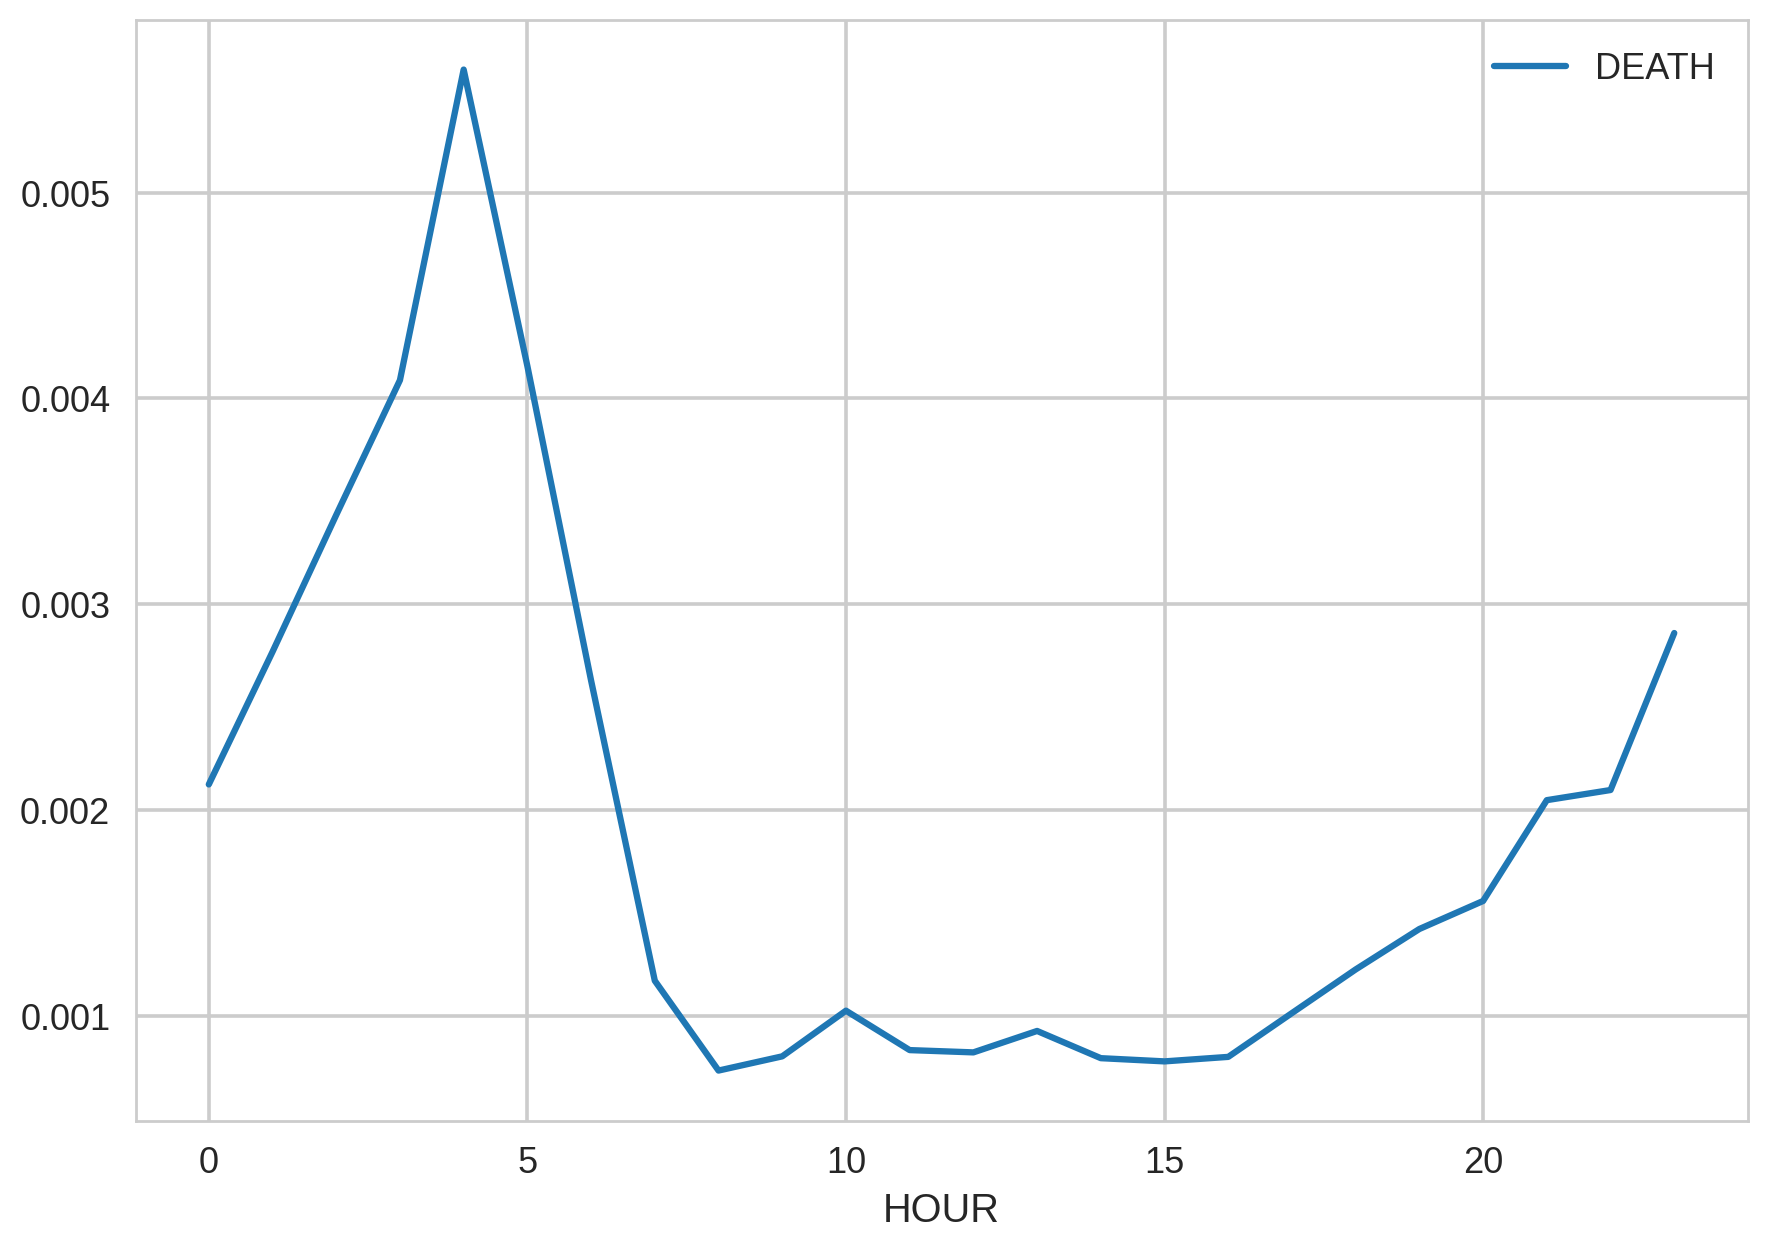

In [43]:
# Alternatively, we can create a line graph

pd.pivot_table(
    data = df,
    index = 'HOUR',
    values = 'DEATH',
    aggfunc = 'mean',
).plot()

In [44]:
injuries = df.query(" INJURY == True ")
no_injuries = df.query(" INJURY == False ")

<Axes: >

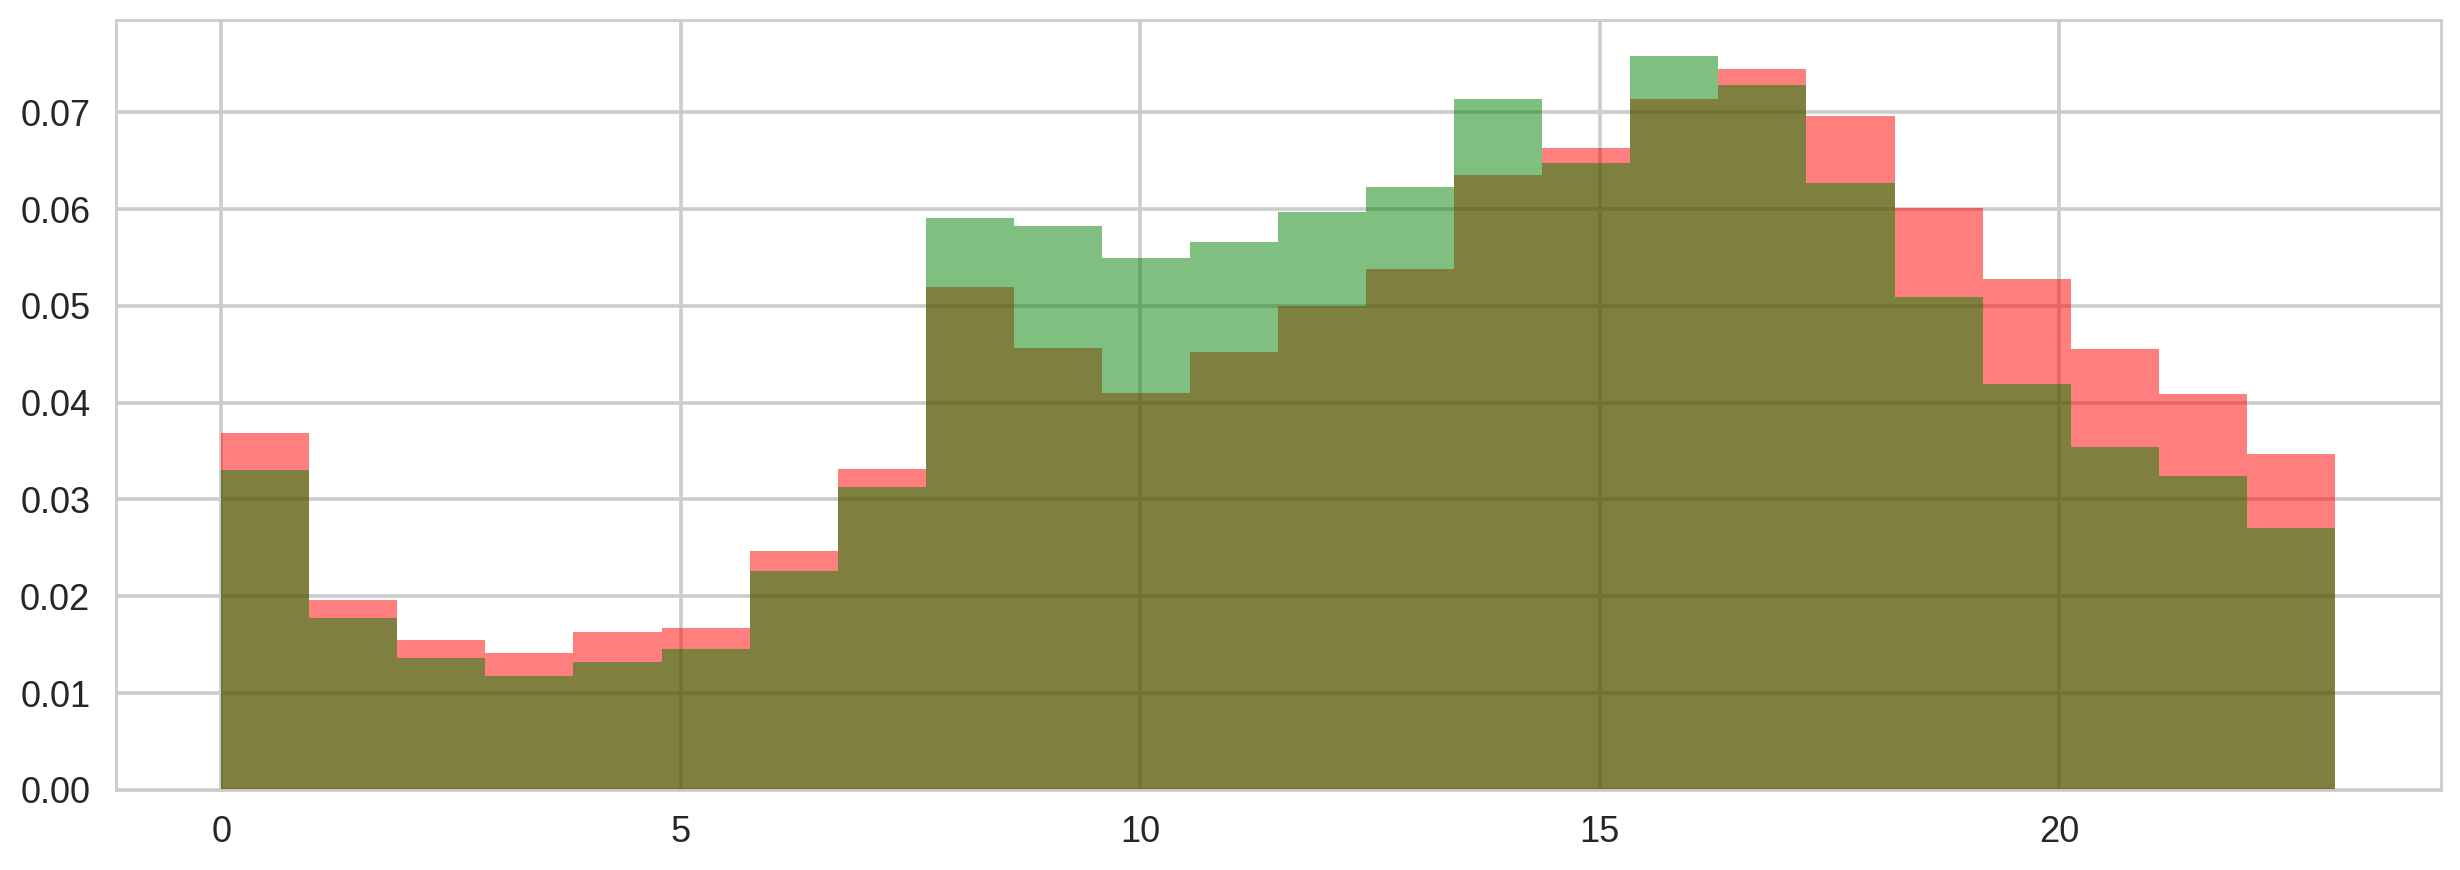

In [45]:
injuries['HOUR'].hist(bins=24,figsize=(15,5), density=True,alpha=0.5, color='red')
no_injuries['HOUR'].hist(bins=24,figsize=(15,5), density=True,alpha=0.5, color='green')

<Axes: xlabel='HOUR'>

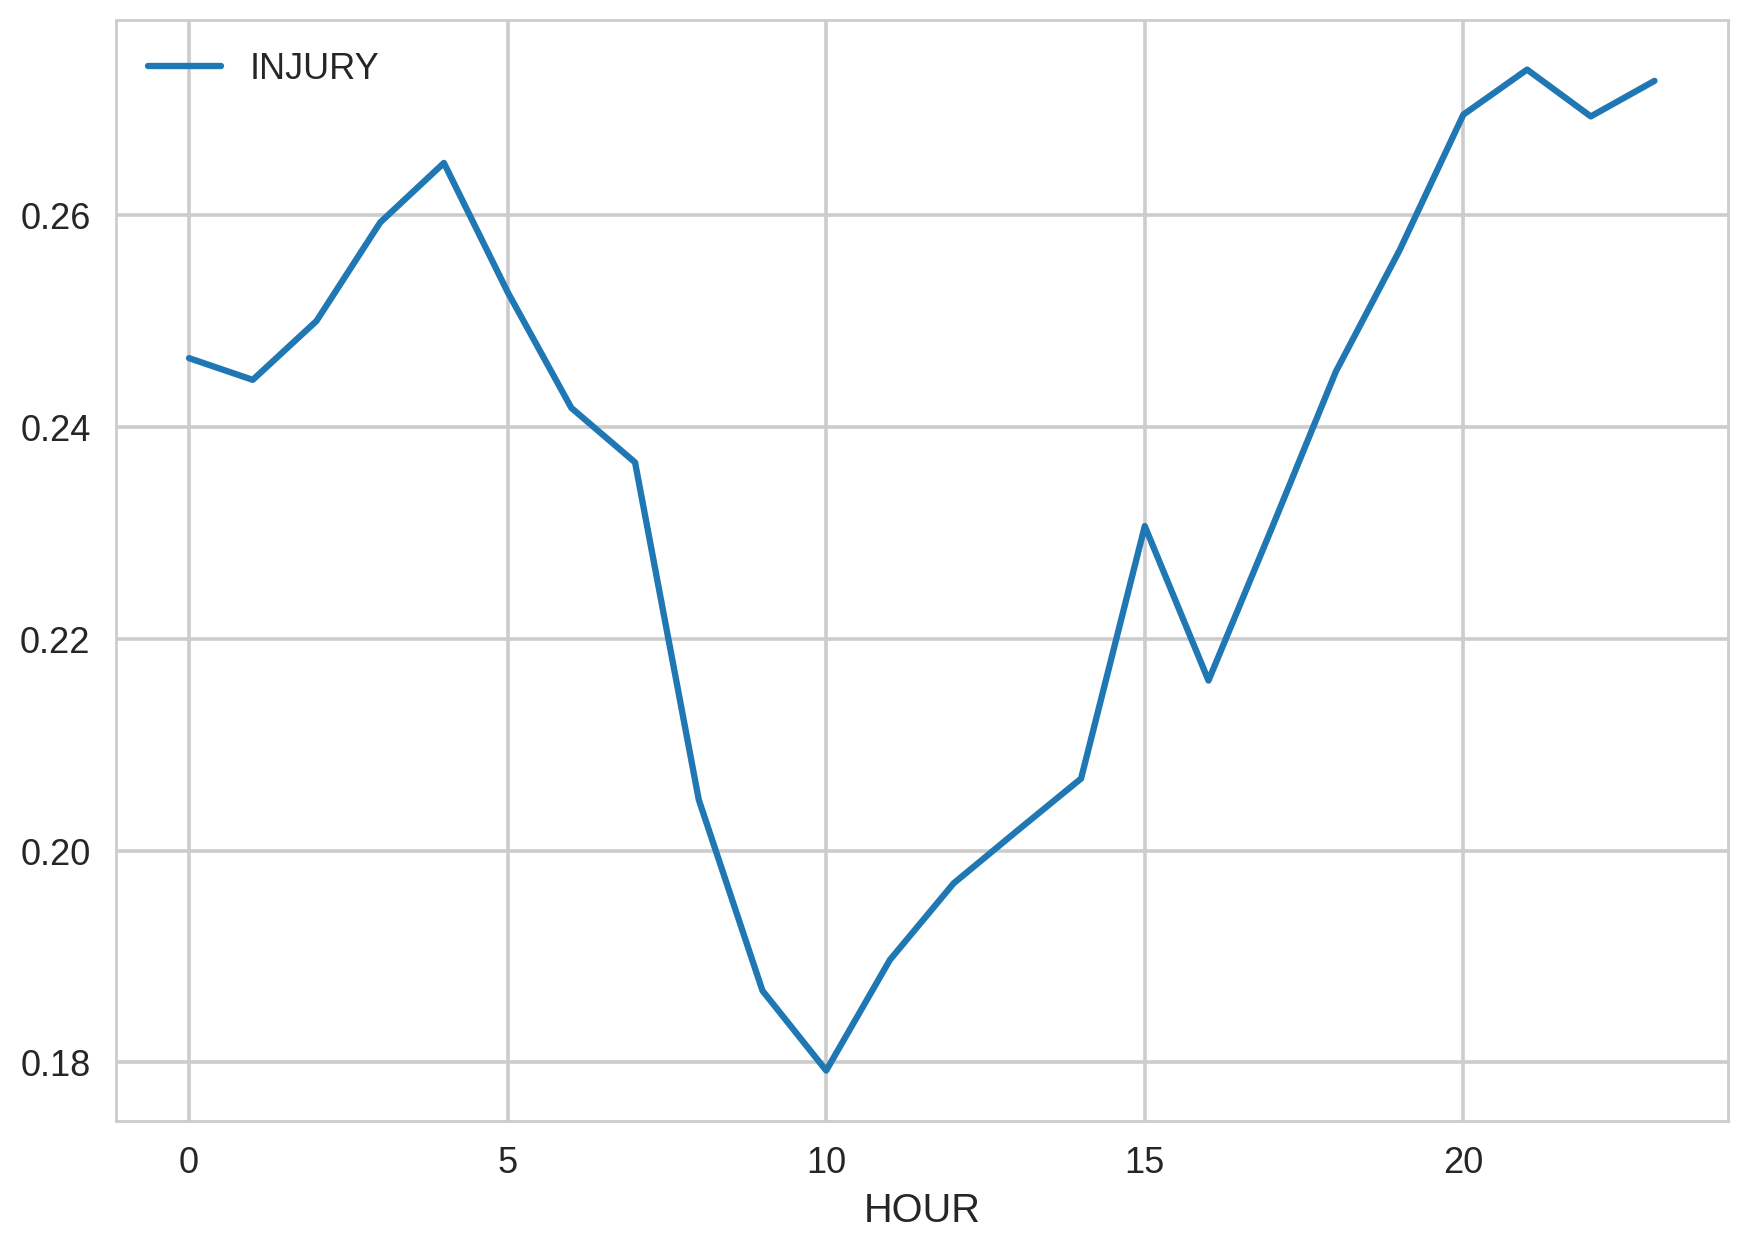

In [46]:
# Alternatively:

pd.pivot_table(
    data = df,
    index = 'HOUR',
    values = 'INJURY',
    aggfunc = 'mean',
).plot()

##And let's do the same analysis over time


<Axes: >

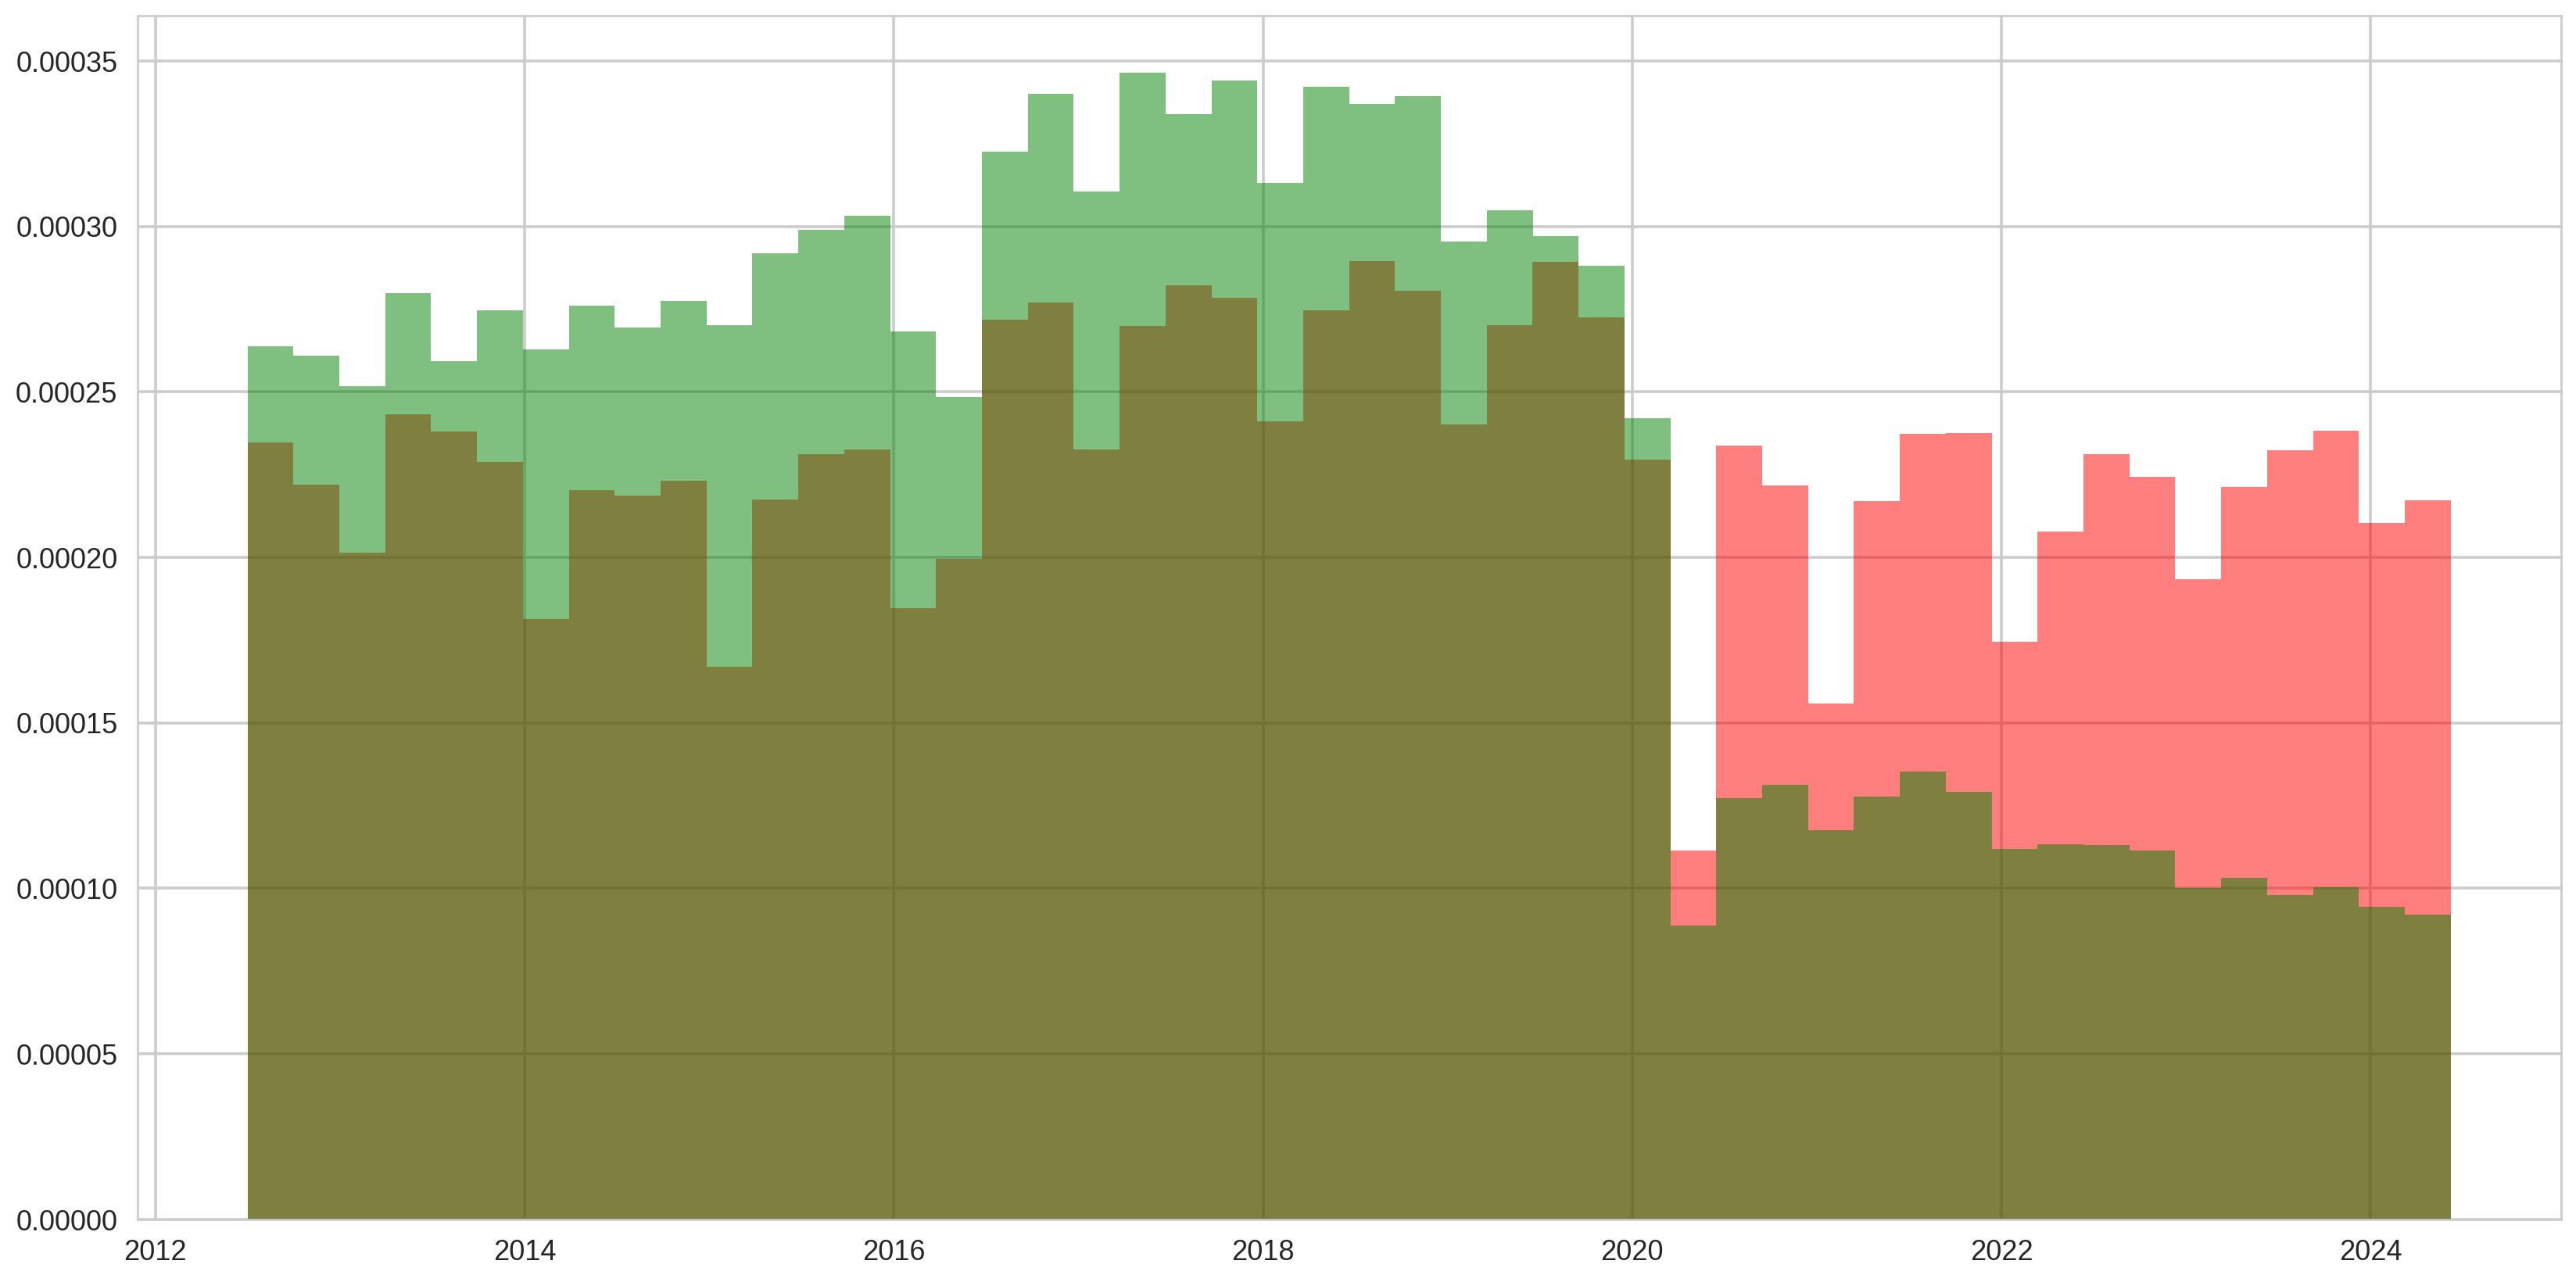

In [48]:
injuries['DATE_TIME'].hist(bins=48,figsize=(20,10), density=True,alpha=0.5, color='red')
no_injuries['DATE_TIME'].hist(bins=48,figsize=(20,10), density=True,alpha=0.5, color='green')

<Axes: xlabel='DATE_TIME'>

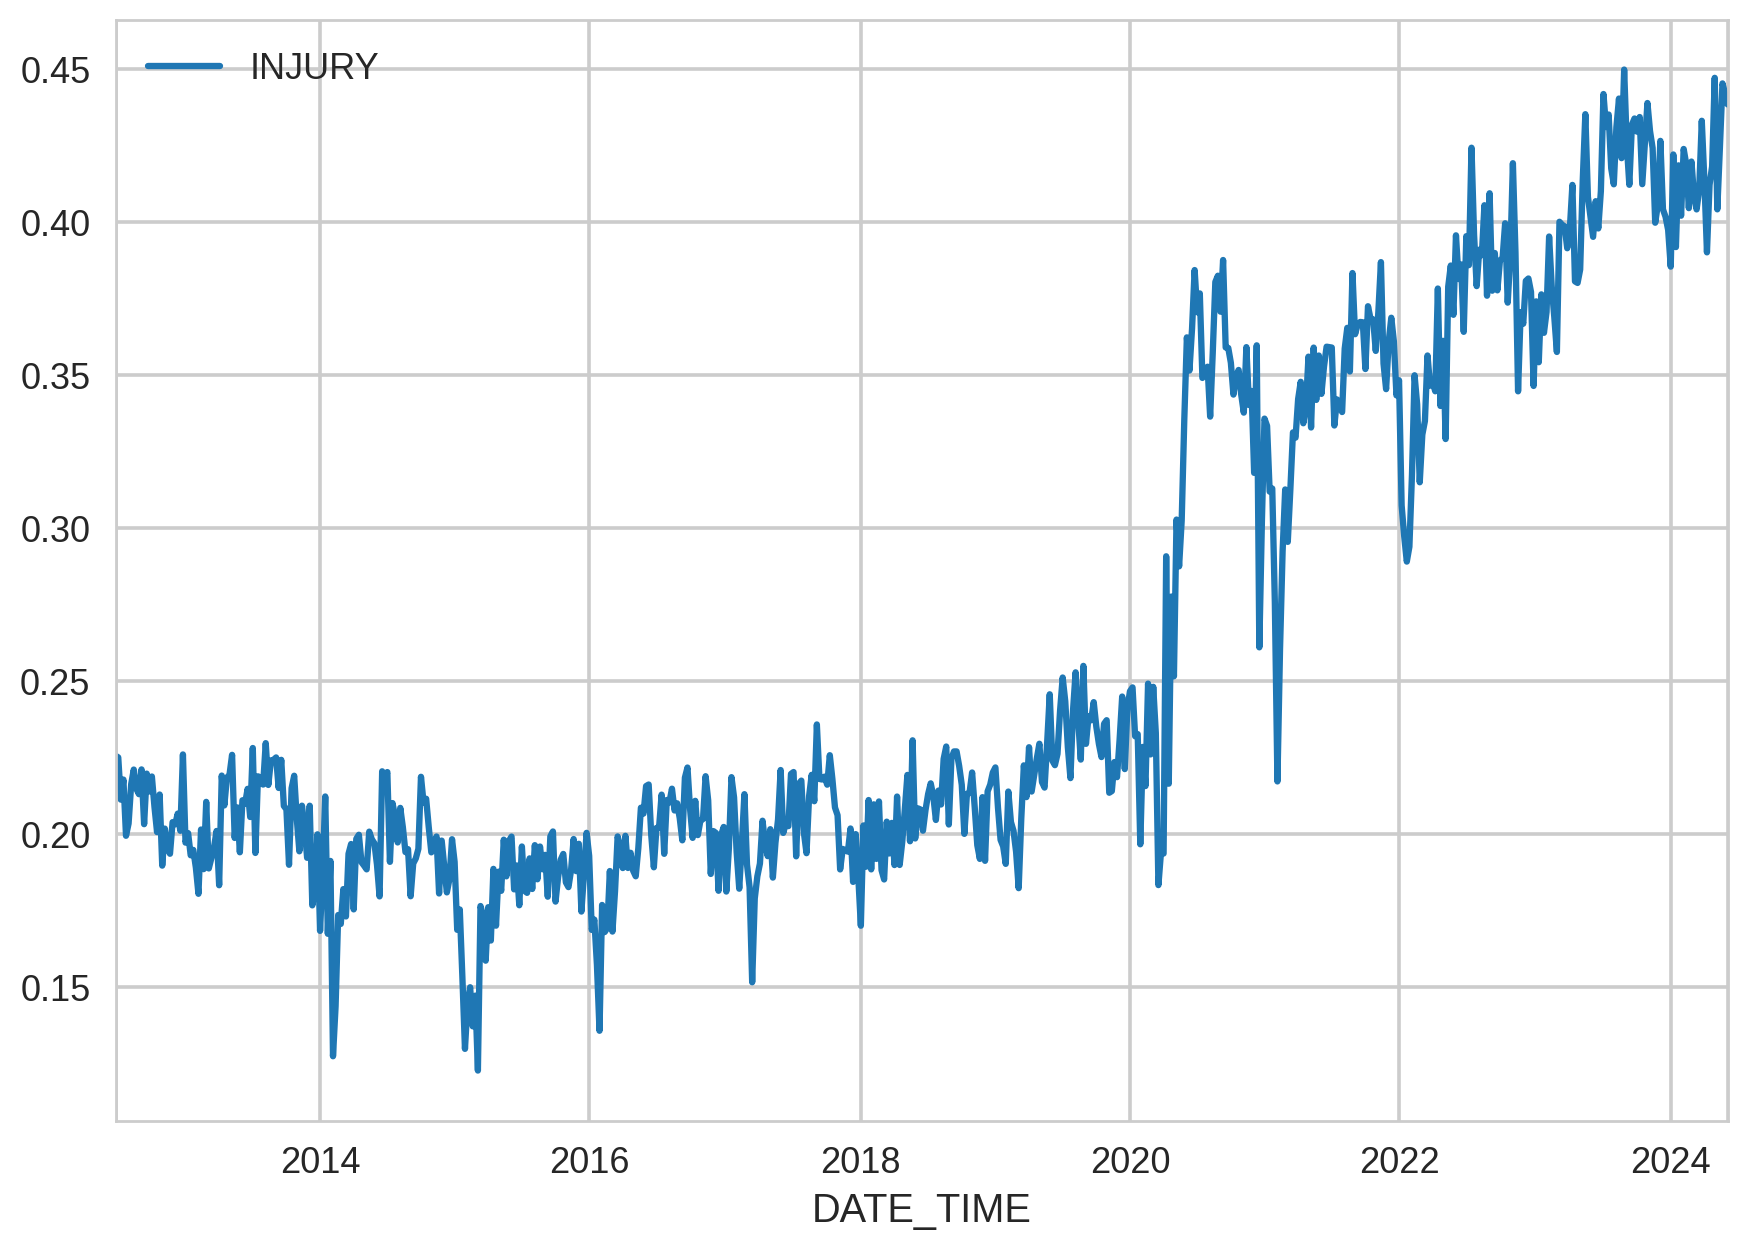

In [49]:
pd.pivot_table(
    data = df,
    index = 'DATE_TIME',
    values = 'INJURY',
    aggfunc = 'mean',
).resample('1W').mean().plot()

<Axes: >

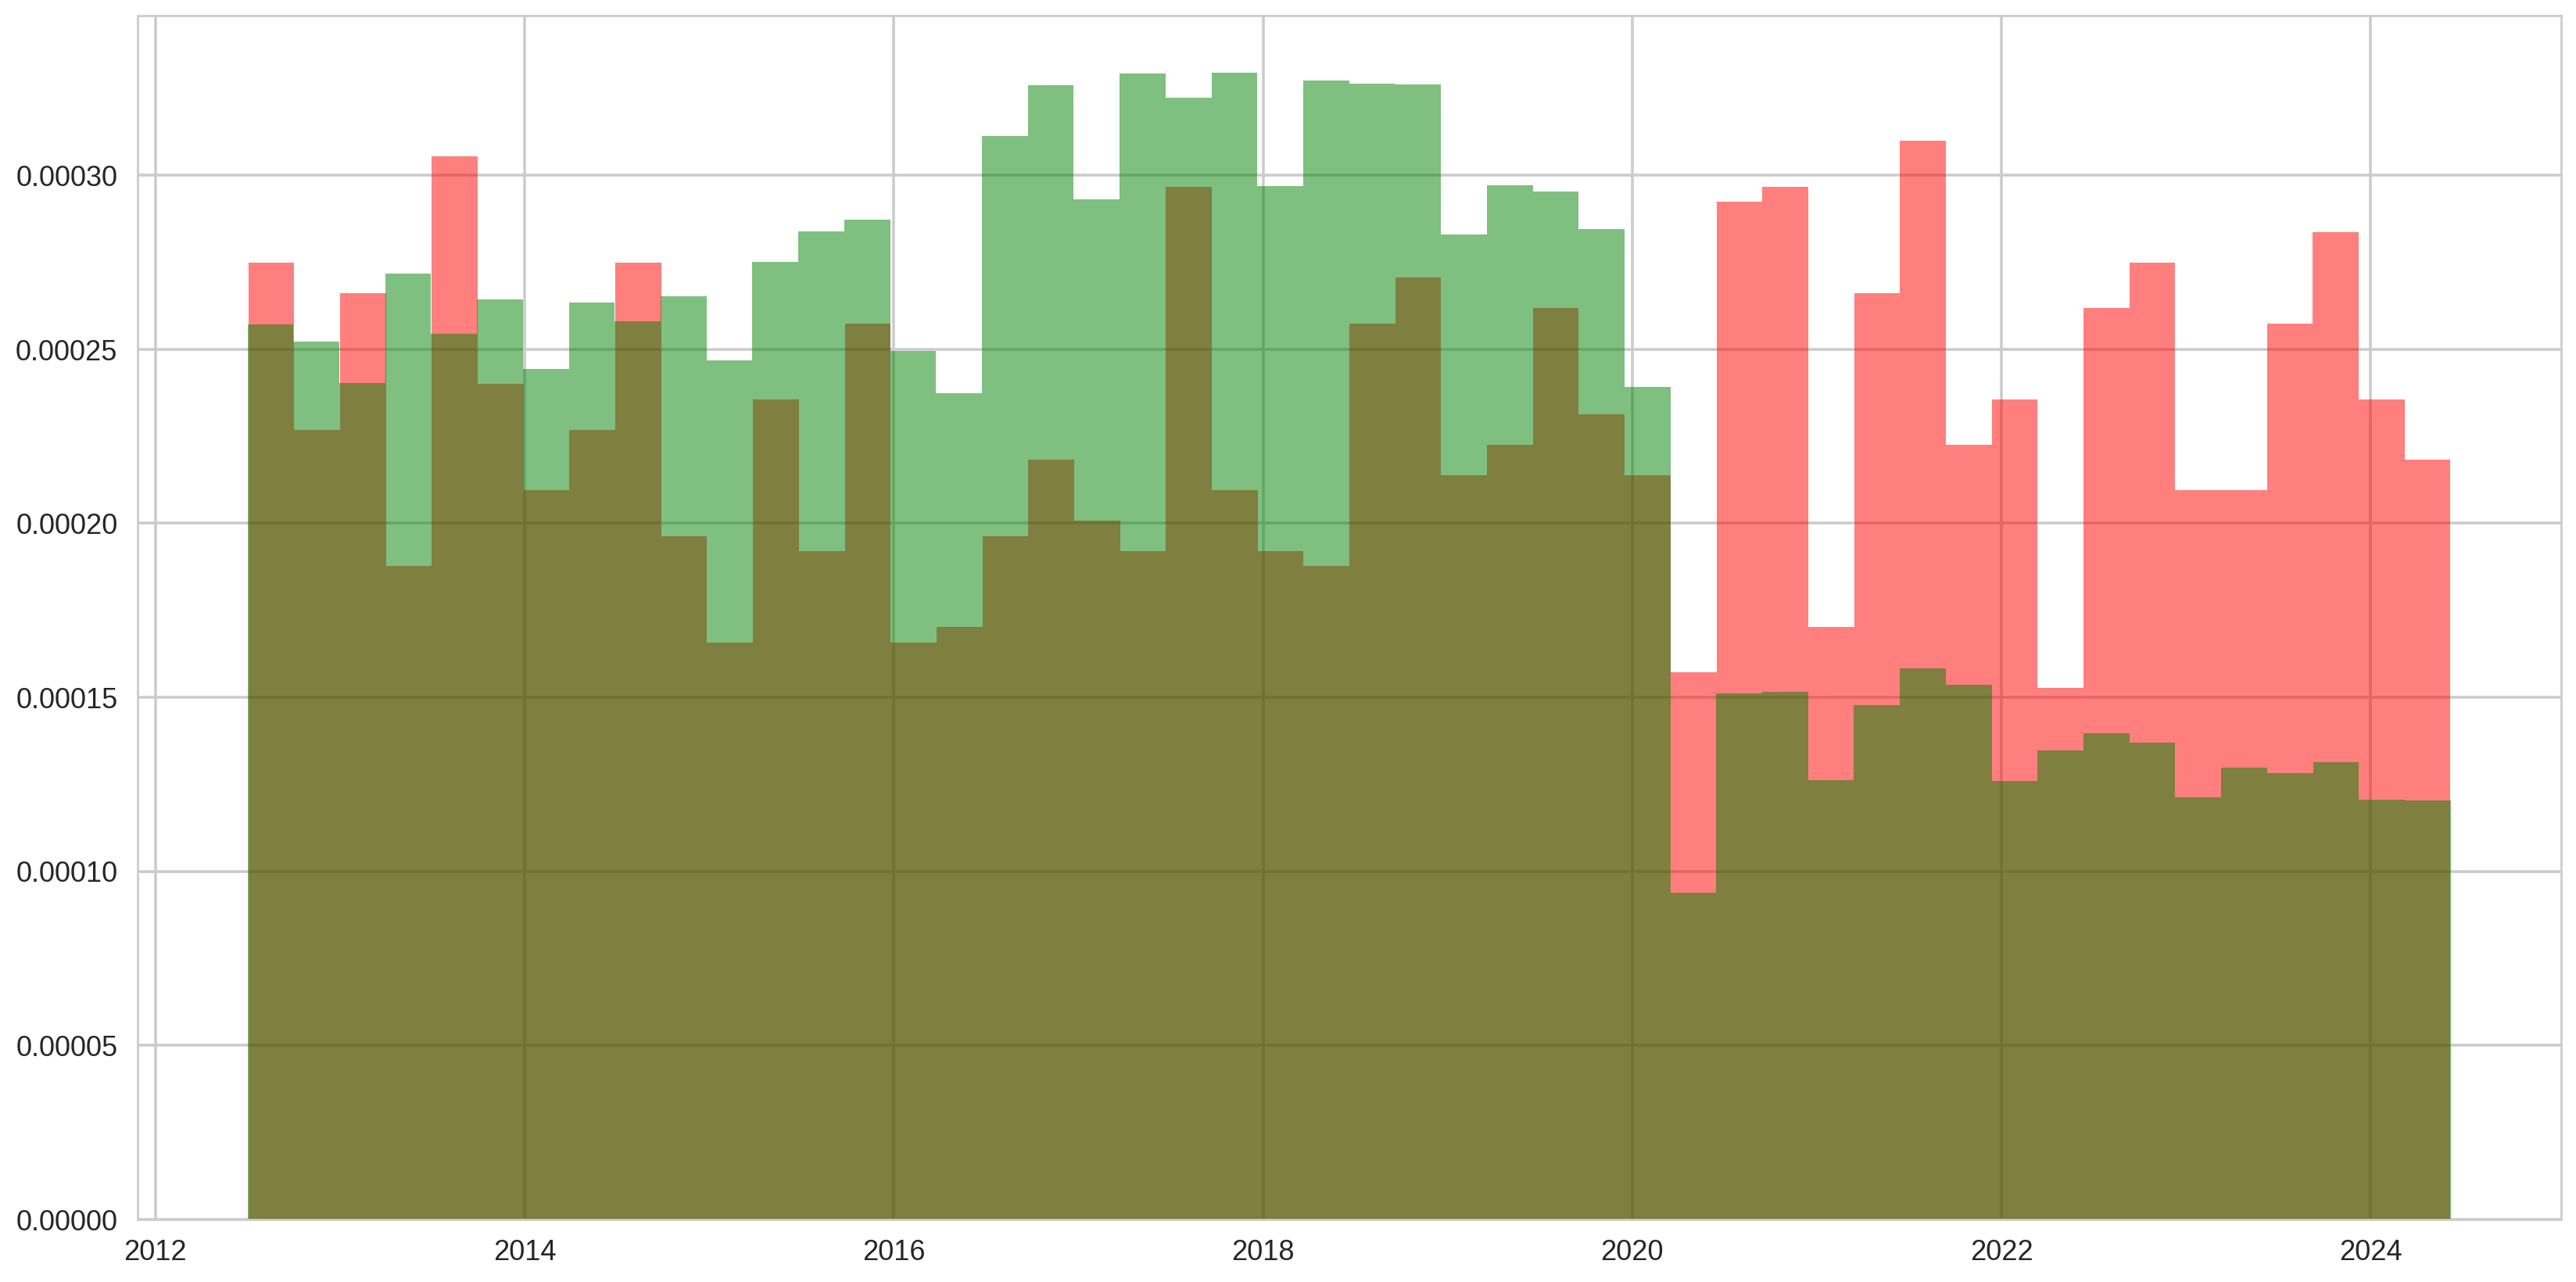

In [50]:
deadly['DATE_TIME'].hist(bins=48,figsize=(20,10), density=True,alpha=0.5, color='red')
noharm['DATE_TIME'].hist(bins=48,figsize=(20,10), density=True,alpha=0.5, color='green')


<ipython-input-51-c18fbdc2299b>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ).resample('1M').mean().plot()


<Axes: xlabel='DATE_TIME'>

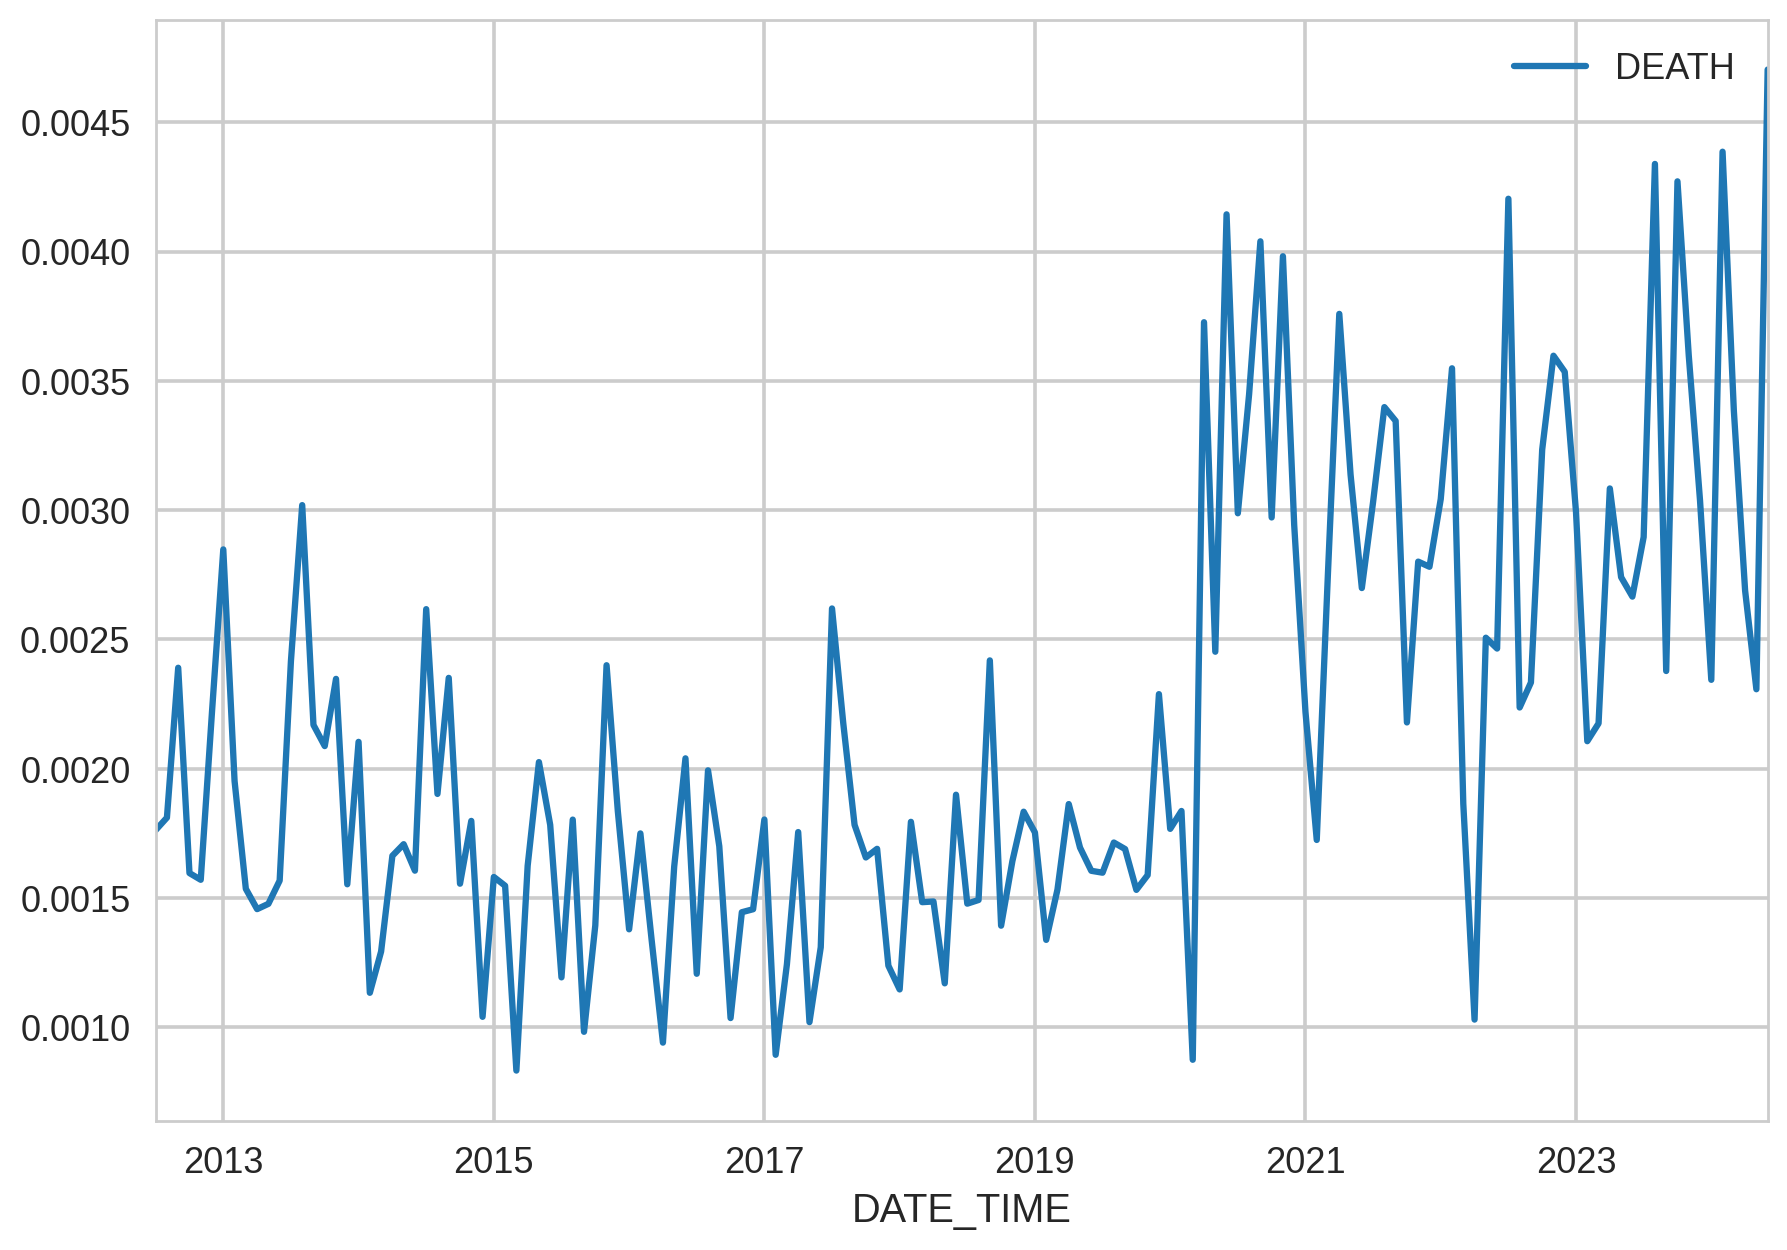

In [51]:
pd.pivot_table(
    data = df,
    index = 'DATE_TIME',
    values = 'DEATH',
    aggfunc = 'mean',
).resample('1M').mean().plot()

<Axes: xlabel='HOUR', ylabel='Density'>

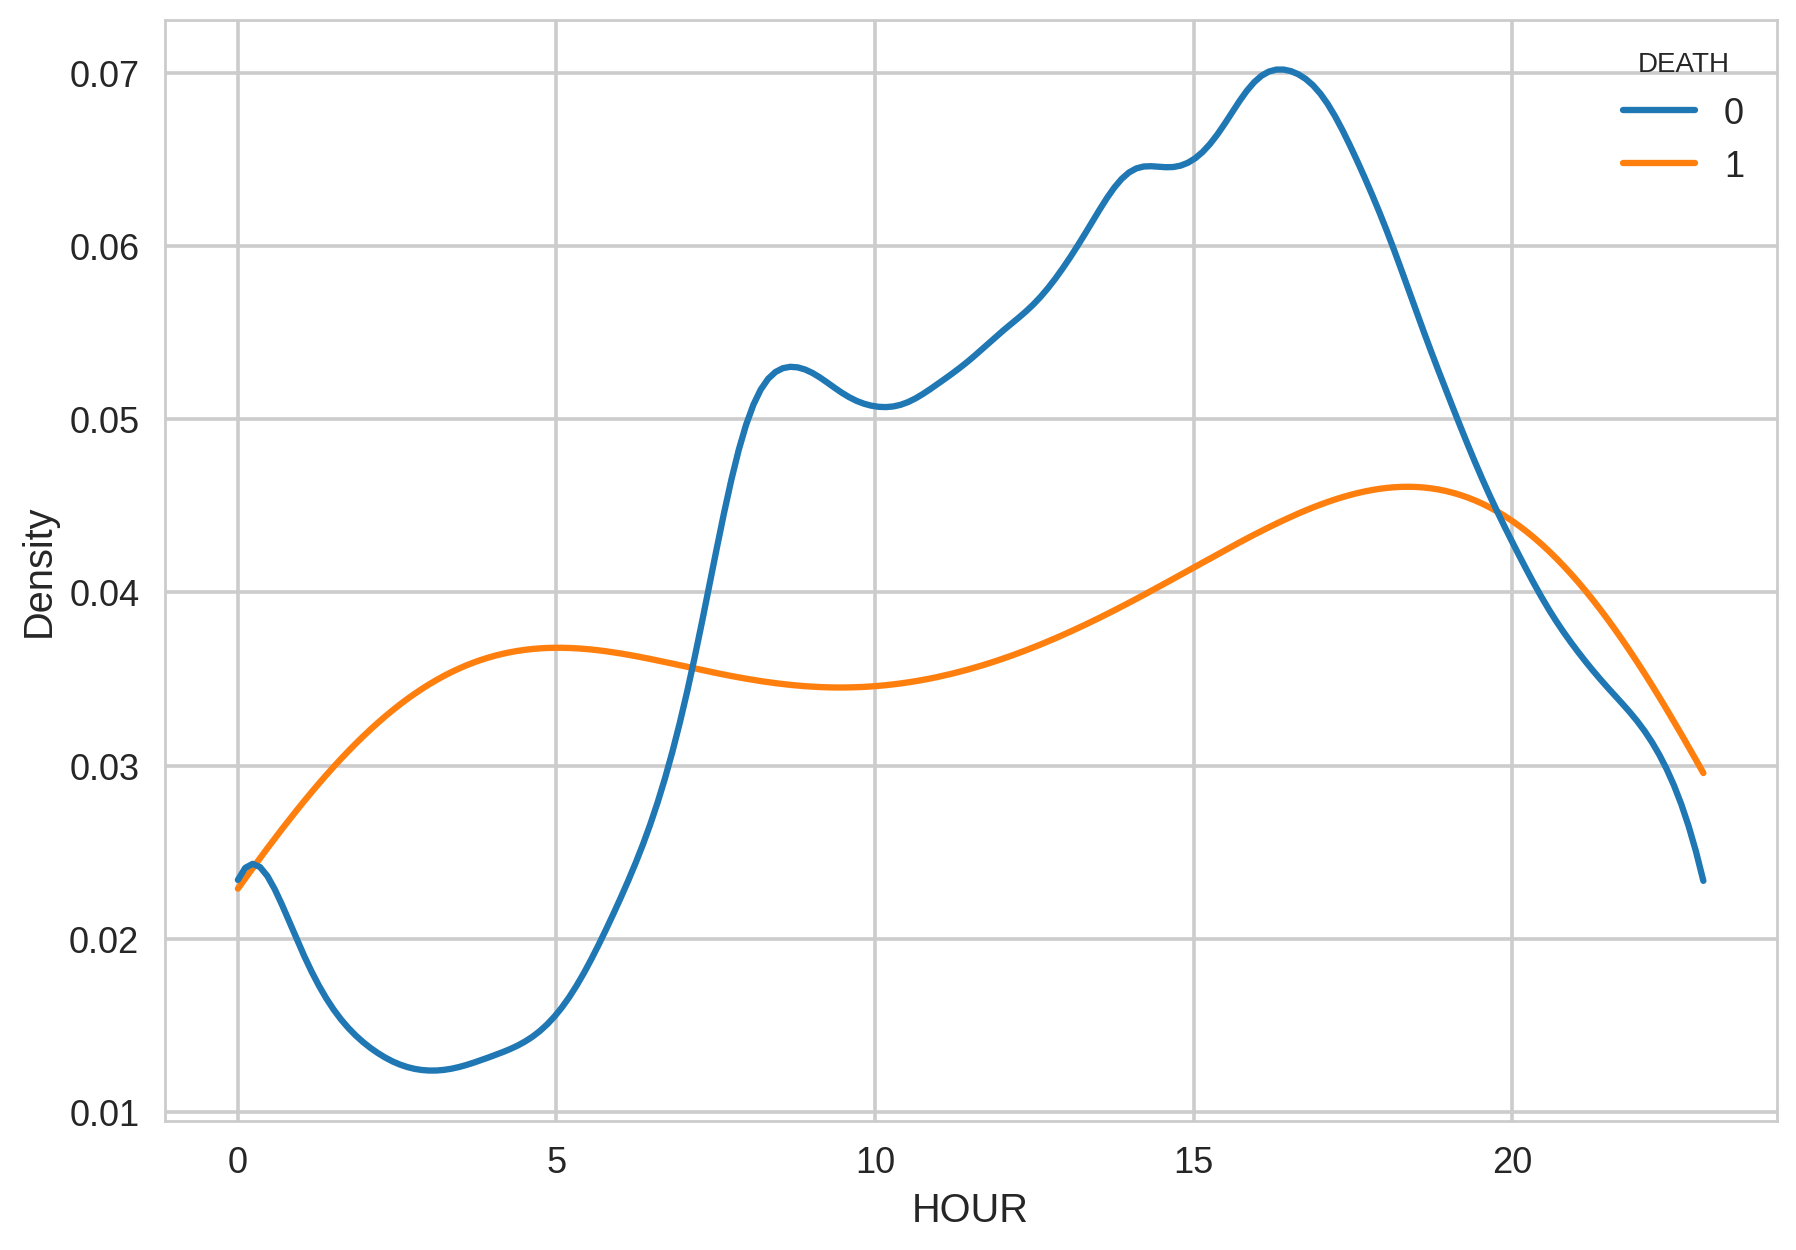

In [52]:
import seaborn as sns
sns.kdeplot(data = df, x ='HOUR', hue='DEATH', common_norm=False, bw_adjust=2, cut=0)


<Axes: xlabel='HOUR', ylabel='Density'>

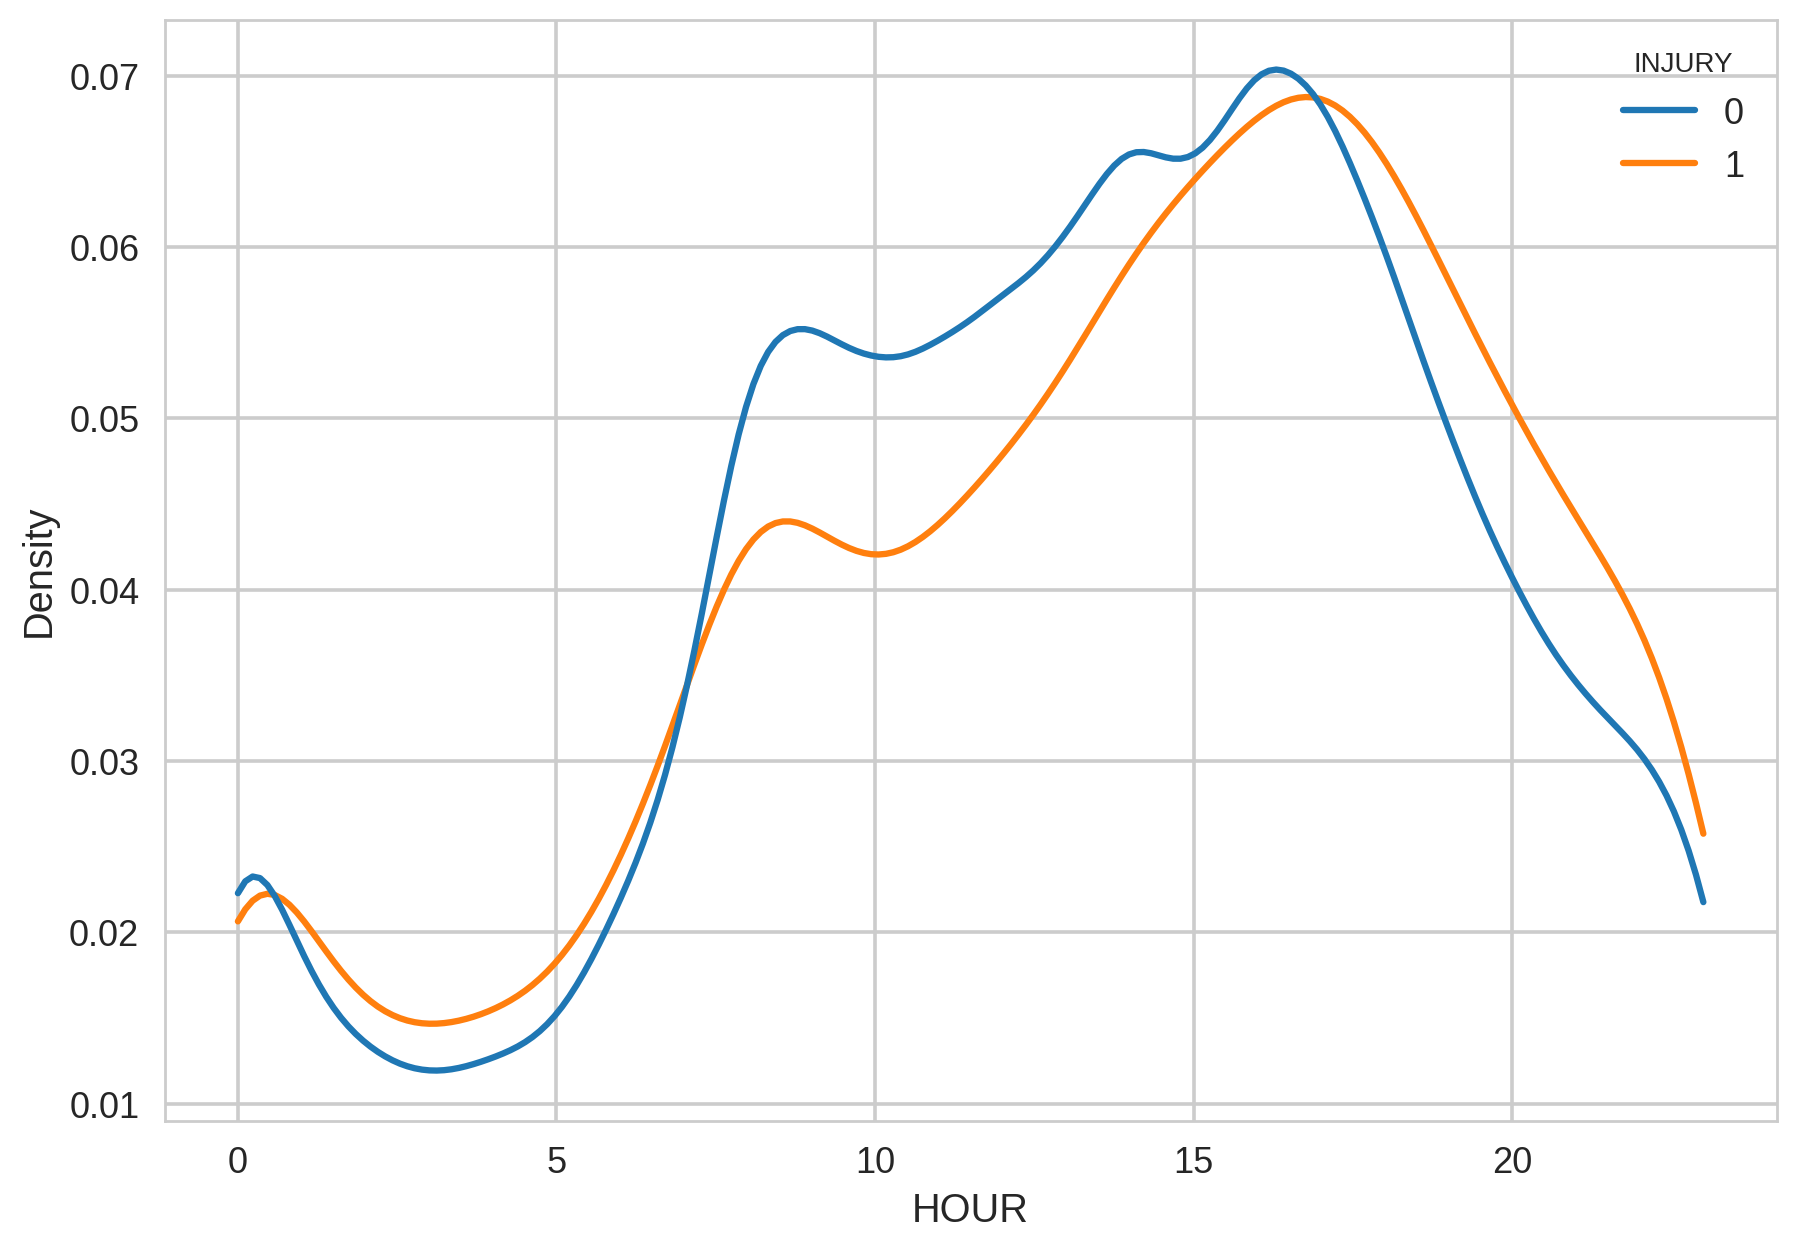

In [53]:
sns.kdeplot(data = df, x ='HOUR', hue='INJURY', common_norm=False, bw_adjust=2, cut=0)


Create a plot that shows the locations of the cyclist deaths. Filter first for accidents where there was a cyclist fatality, and then use a scatterplot on longitude and latitude. In the next step, create a 2-d kernel density plot to show the same information.

In [54]:
sql = "SELECT LONGITUDE, LATITUDE FROM collisions WHERE CYCLISTS_KILLED > 0"

with engine.connect() as connection:
	cyclist_dead = pd.read_sql(text(sql), con=connection)

<Axes: xlabel='LONGITUDE', ylabel='LATITUDE'>

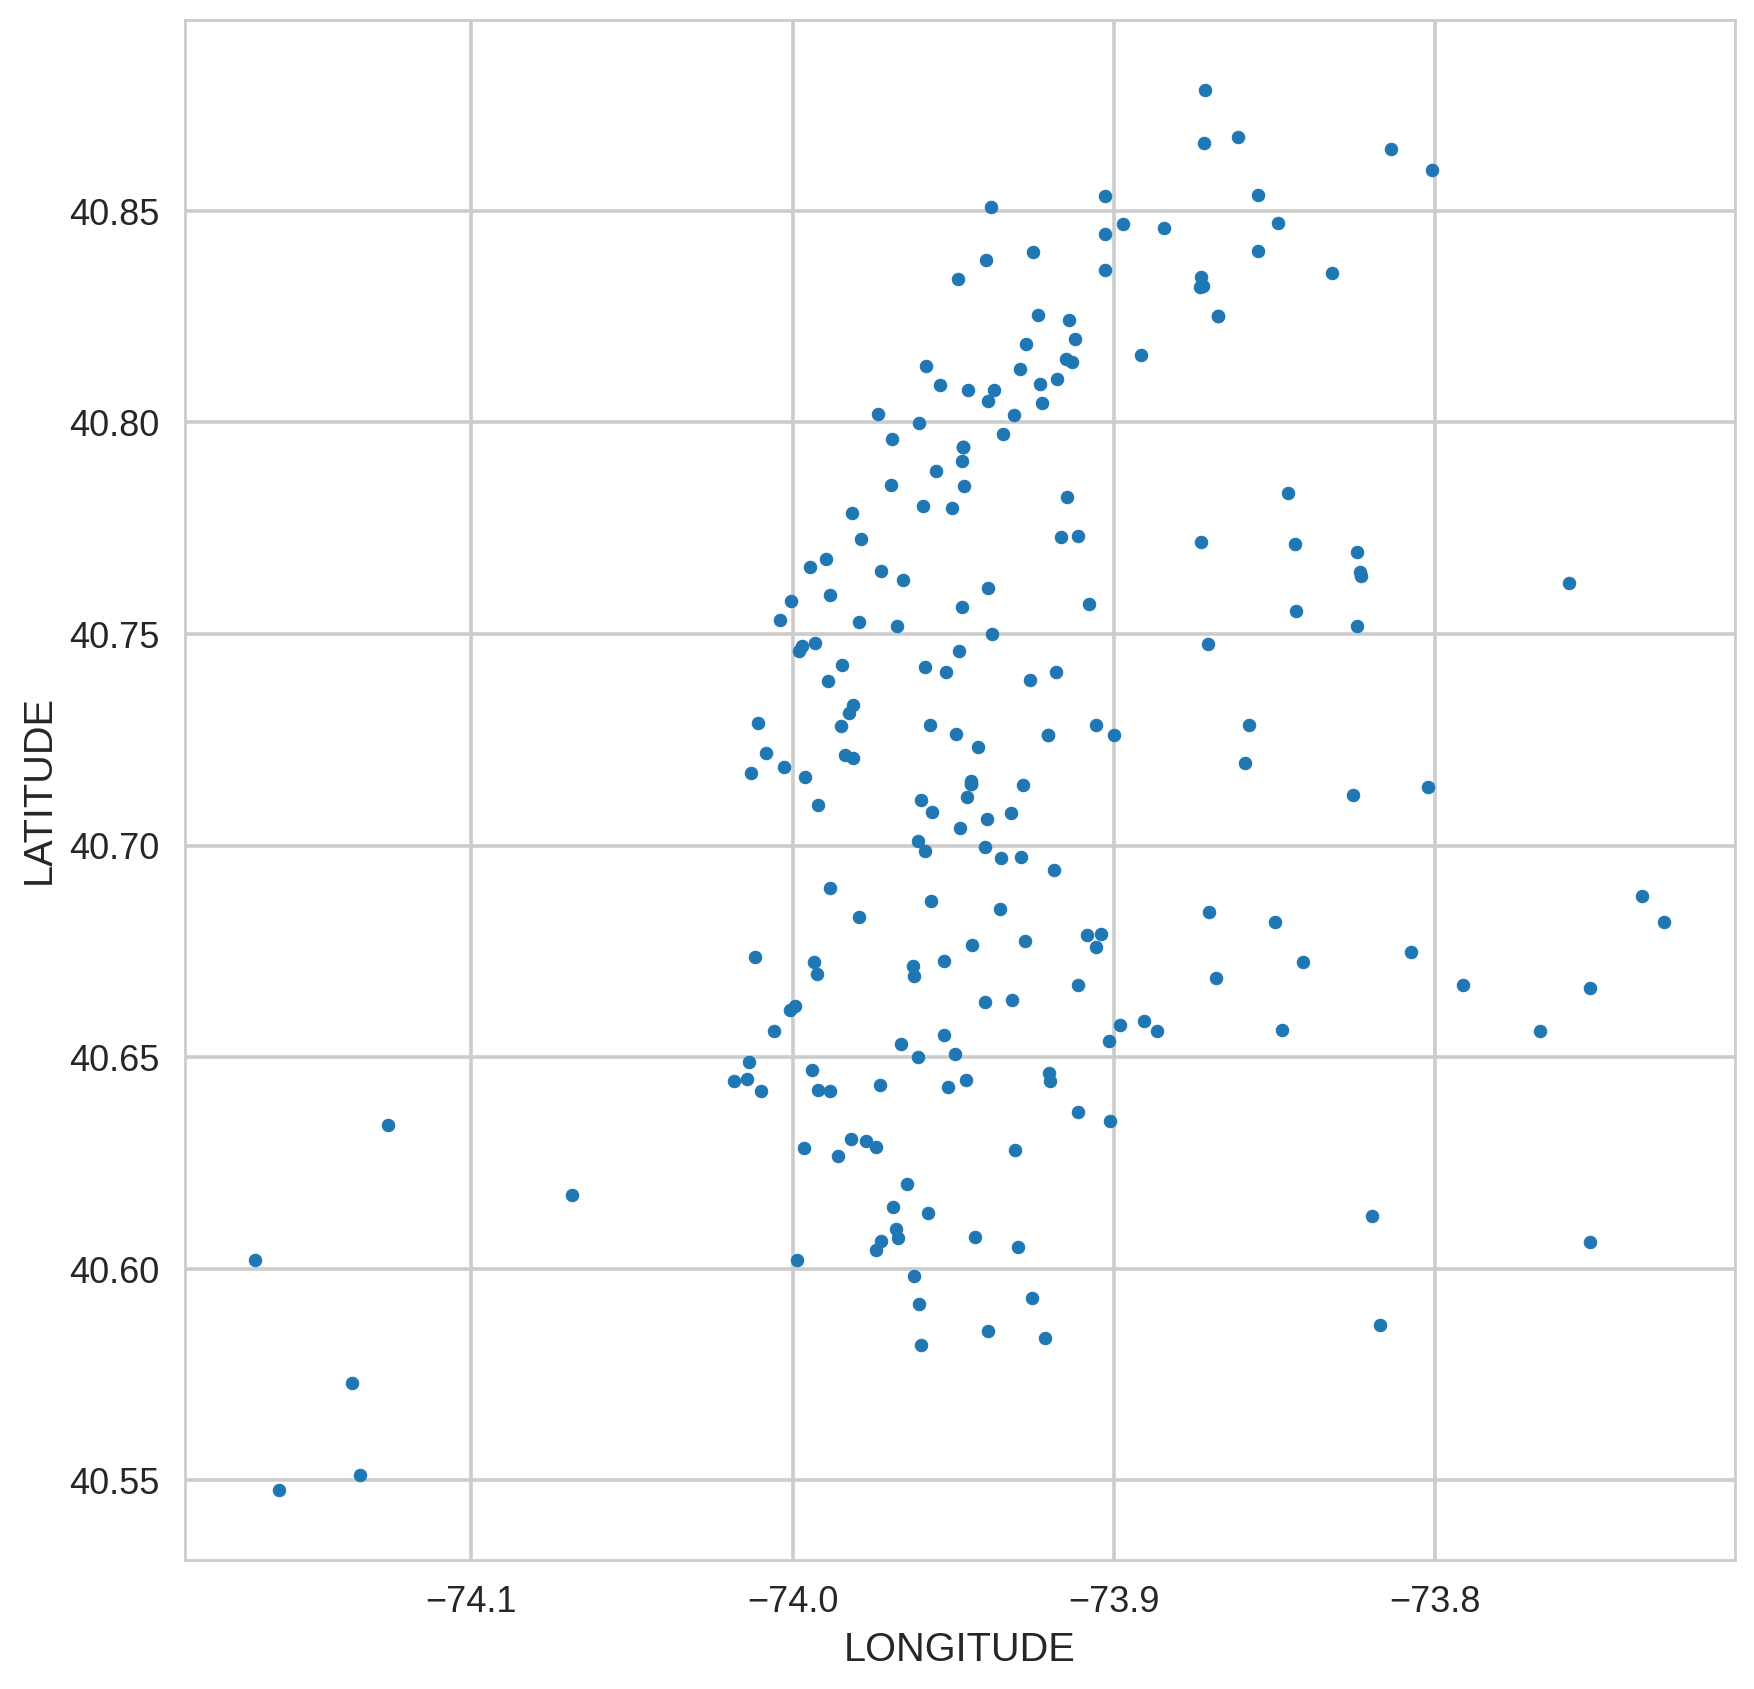

In [55]:
(
    cyclist_dead
    .plot(
        kind='scatter',
        x='LONGITUDE',
        y='LATITUDE',
        # s=1,
        figsize=(10,10)
    )
)

<ipython-input-56-5c4a44c0a81e>:11: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(


<Axes: xlabel='LONGITUDE', ylabel='LATITUDE'>

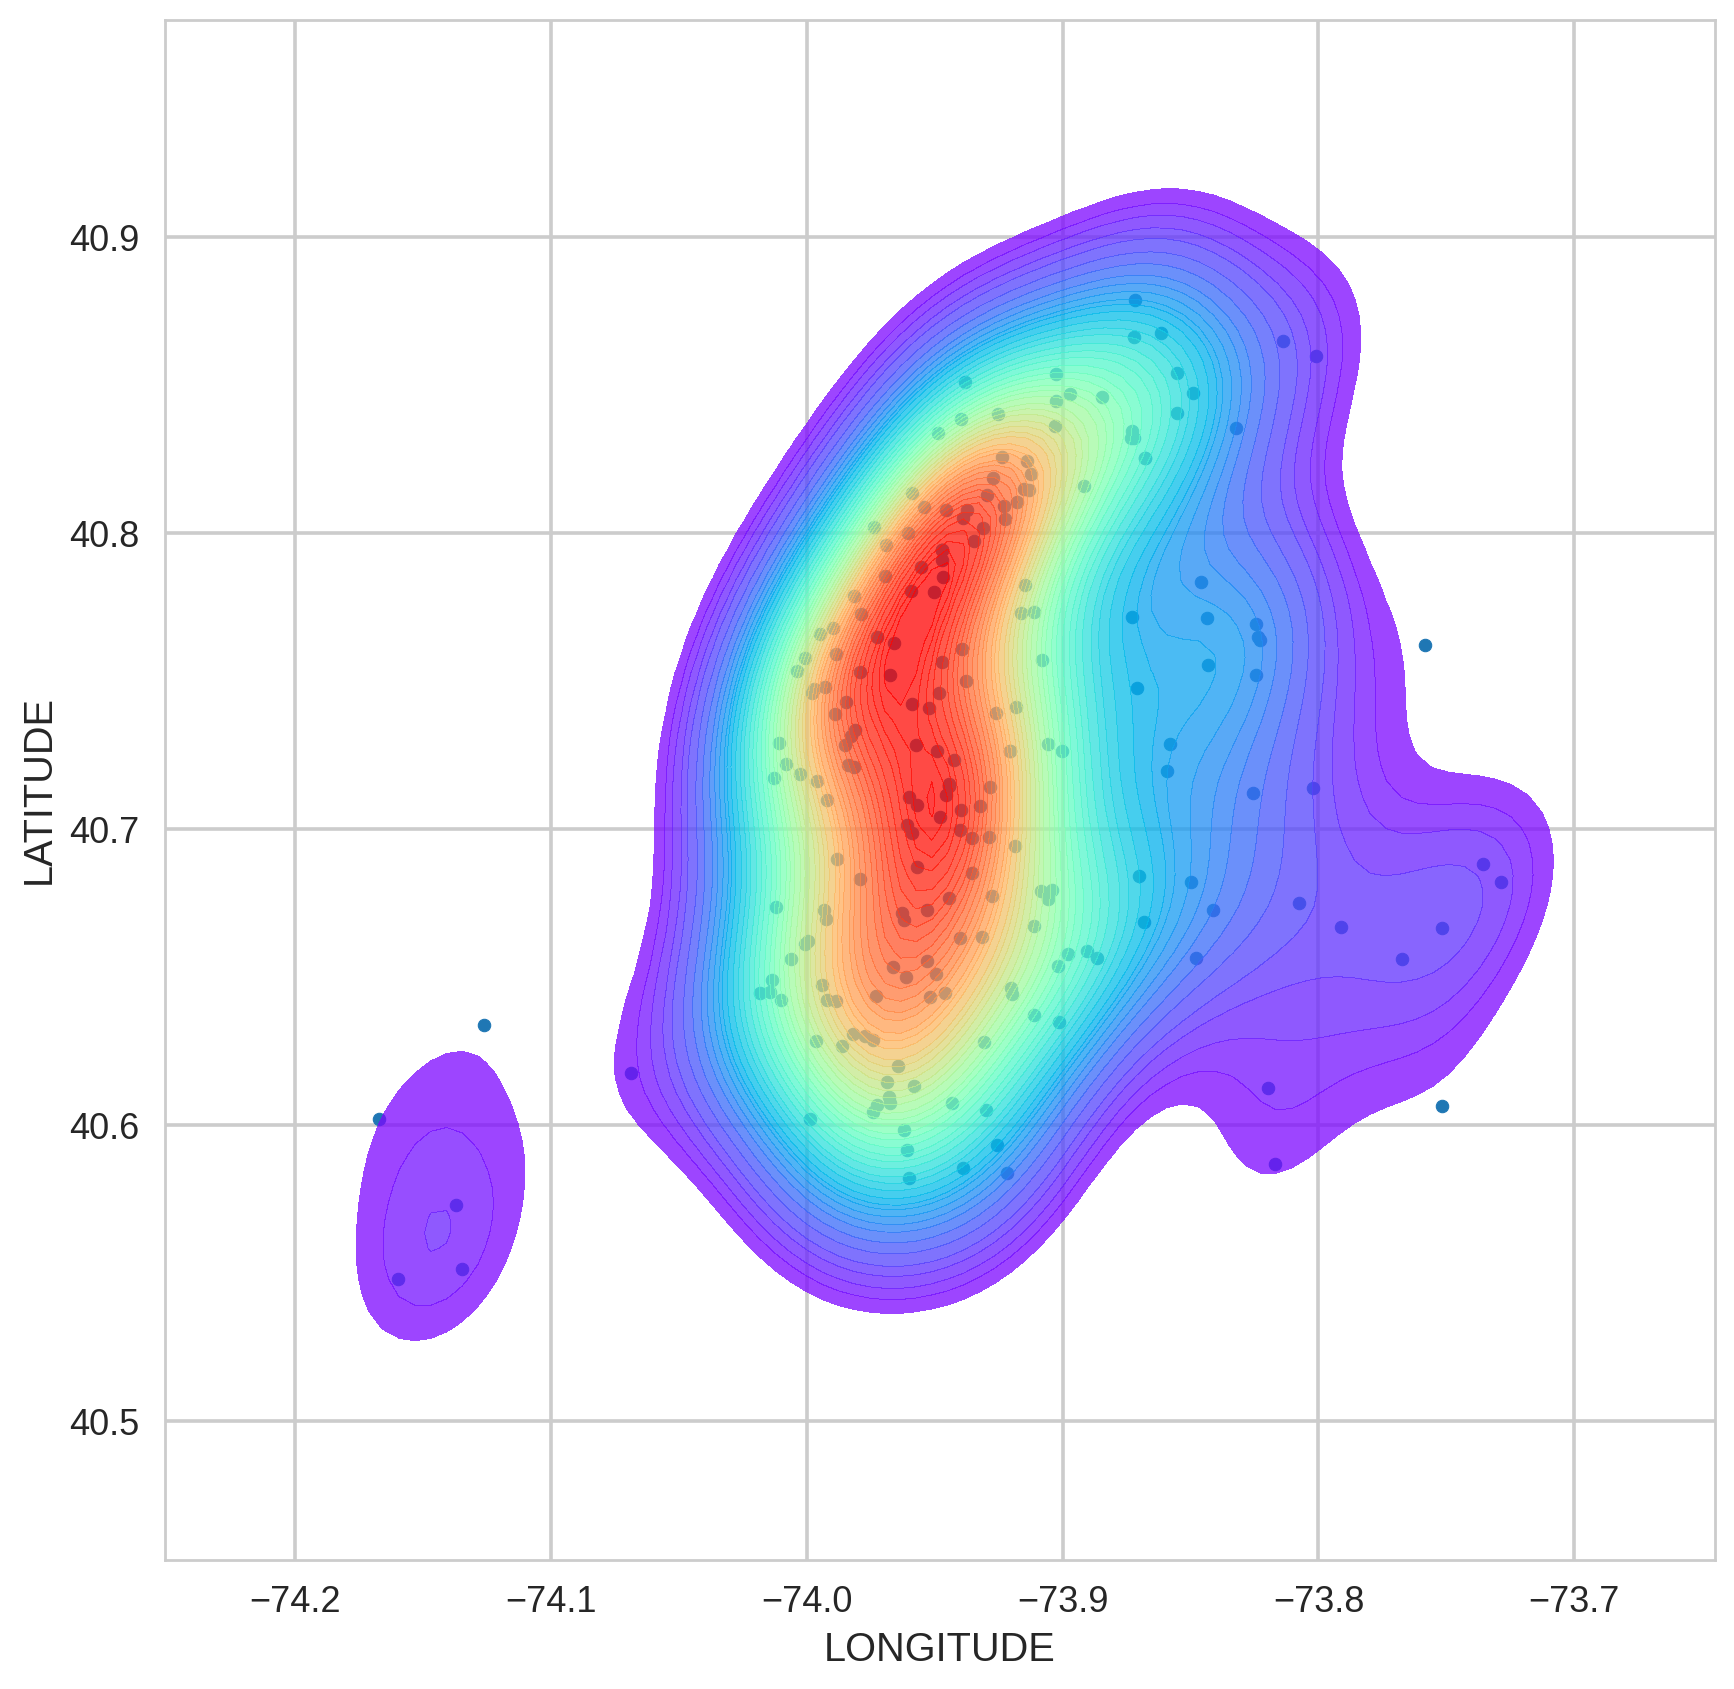

In [56]:
scatter = (
    cyclist_dead
    .plot(
        kind='scatter',
        x='LONGITUDE',
        y='LATITUDE',
        figsize=(10,10)
    )
)

sns.kdeplot(
    data = cyclist_dead,
    x='LONGITUDE',
    y='LATITUDE',
    shade=True,
    gridsize=100,
    cmap='rainbow',
    alpha=0.75,
    n_levels=50,
    ax=scatter
)

In [57]:
base = df_nyc.plot(
    linewidth=0.5,
    color='White',
    edgecolor='Black',
    figsize=(10, 10),
    alpha=0.75
)

scatter = (
    cyclist_dead
    .plot(
        kind='scatter',
        x='LONGITUDE',
        y='LATITUDE',
        ax = base # plot it on top of the NYC boundaries
    )
)

sns.kdeplot(
    data = cyclist_dead,
    x='LONGITUDE',
    y='LATITUDE',
    shade=True, # Whether to color between the levels (True) or just keep the contours
    gridsize=100, # The resoltion of the 2d plot
    cmap='rainbow', # Color scheme
    alpha=0.5, # make the 2d density plot a bit transparent
    n_levels=20, # calculate 20 levels for the 2d density plot
    ax=scatter # plot it on top of the scatter plot
)

NameError: name 'df_nyc' is not defined